## Preliminaries

In [2]:
import numpy as np, matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import scipy

In [3]:
# Read in the mc
neutrinos = np.genfromtxt("./neutrino_mc.csv", delimiter=',', names=True)
muons = np.genfromtxt("./muon_mc.csv", delimiter=',', names=True)

In [4]:
# Read in the hyperplane parameters
hp_nue_cc = np.genfromtxt("./hyperplanes_nue_cc.csv", delimiter=',', names=True)
hp_numu_cc = np.genfromtxt("./hyperplanes_numu_cc.csv", delimiter=',', names=True)
hp_nutau_cc = np.genfromtxt("./hyperplanes_nutau_cc.csv", delimiter=',', names=True)
hp_nu_nc = np.genfromtxt("./hyperplanes_all_nc.csv", delimiter=',', names=True)
hp_muons = np.genfromtxt("hyperplanes_muon.csv", delimiter=',', names=True)

In [5]:
# The bestfit values for Analysis A NC+CC from Table 2
best_fit = {'ice_absorption': 101.5,
            'ice_scattering': 103.0,
            'opt_eff_headon': -0.63,
            'opt_eff_lateral': 0.49,
            'opt_eff_overall': 98.4,
            'coin_fraction': 0.01,
            'delta_m32': 2.53e-3,
            'theta_23': 49.8,
            'nu_tau_norm': 0.73,
            'NC_norm': 1.05}

## Functions

In [6]:
# Write the function definition for neutrinos
# This will take the values for each parameter and return the modified weight for each event
def apply_neutrinos(neutrinos=neutrinos,
                    hyperplanes = {0: hp_nu_nc,
                                   12: hp_nue_cc,
                                   14: hp_numu_cc,
                                   16: hp_nutau_cc,},
                    ice_absorption = 100.0,
                    ice_scattering = 100.0,
                    opt_eff_headon = 0.0,
                    opt_eff_lateral = 0.0,
                    opt_eff_overall = 100.0,
                    coin_fraction = 0.0,
                    **kwargs):
    
    # Copy the weights so we can modify them and 
    # assign an "interaction type" corresponding to
    # nue CC, numu CC, nutau CC or NC
    output_weights = np.copy(neutrinos['weight'])
    int_type = np.copy(neutrinos['pdg']).astype(int)
    int_type[neutrinos['type']==0] = 0 
    int_type = np.abs(int_type)

    # Apply each neutrino flavor separately using the PDG
    # codes for each. Note that we're using 0 for NC interactions
    # and 12/14/16 for nue/numu/nutau CC interactions respectively
    for flavor, hp in hyperplanes.items():
        bins_cz = -hyperplanes[flavor]['reco_coszen'] # Wrong sign of coszen, Tania
        bins_en = hyperplanes[flavor]['reco_energy']
        bins_pid = hyperplanes[flavor]['pid']
        bins = np.array([bins_cz, bins_en, bins_pid]).T
        
        modifications = hp['offset'] + \
                        hp['ice_scattering'] * (ice_scattering-100)/100. +\
                        hp['ice_absorption'] * (ice_absorption-100)/100. +\
                        hp['opt_eff_lateral'] * (10*opt_eff_lateral) +\
                        hp['opt_eff_headon'] * (opt_eff_headon) +\
                        hp['opt_eff_overall'] * (opt_eff_overall-100)/100. +\
                        hp['coin_fraction'] * (coin_fraction)
        
        # Apply the modifications for a single neutrino flavor
        for i, b in enumerate(bins):
            mask = (int_type==flavor)
            mask &= (neutrinos['reco_coszen'] == b[0]) # TBD: Check if sign is correct. Should be fine because MC has no wrong sign
            mask &= (neutrinos['reco_energy'] == b[1])
            mask &= (neutrinos['pid'] == b[2])
            output_weights[mask] *= modifications[i]
        
    return output_weights
        

In [7]:
# Write the function definition for muons
# This will take the values for each parameter and return the modified weight for each event
def apply_muons(muons=muons,
                hyperplane = hp_muons,
                ice_absorption = 100.0,
                ice_scattering = 100.0,
                opt_eff_headon = 0.0,
                opt_eff_lateral = 0.0,
                opt_eff_overall = 100.0,
                **kwargs):
    
    # Copy the weights so we can modify them
    output_weights = np.copy(muons['weight'])

    # Get the bins for the muons
    bins_cz = -hyperplane['reco_coszen'] # Wrong sign of coszen, Tania
    bins_en = hyperplane['reco_energy']
    bins_pid = hyperplane['pid']
    bins = np.array([bins_cz, bins_en, bins_pid]).T

    # Calculate the modifications    
    modifications = hyperplane['offset'] +\
        hyperplane['ice_scattering']*(ice_scattering-100)/100. +\
        hyperplane['opt_eff_lateral']*(10*opt_eff_lateral) +\
        hyperplane['opt_eff_headon']*(opt_eff_headon) +\
        hyperplane['ice_absorption']*(np.exp(hyperplane['ice_absorption_expslope']*(ice_absorption/100.-1.0))-1) +\
        hyperplane['opt_eff_overall']*(np.exp(hyperplane['opt_eff_overall_expslope']*(opt_eff_overall/100.-1.0))-1)

    total_mask = np.zeros(len(muons)).astype(int)

    # Apply the modifications to the muon weights
    for i, b in enumerate(bins):
        mask = (muons['reco_coszen'] == b[0]) # TBD: Check if sign is correct. Should be fine because MC has no wrong sign
        mask &= (muons['reco_energy'] == b[1])
        mask &= (muons['pid'] == b[2])
        output_weights[mask] *= modifications[i]
        total_mask += mask.astype(int)

    assert (total_mask == 1).all(), "Some muons were not modified, or modified more than once!"
    
    return output_weights
        

In [8]:
# Sanity checks for the code above so that the masks work as intended
for variable in ["reco_energy", "reco_coszen", "pid"]: # TBD: Check if sign is correct
    hp_unique = np.sort(np.unique(hp_muons[variable]))
    for hp_plane in [hp_nu_nc, hp_nue_cc, hp_numu_cc, hp_nutau_cc]:
        assert np.all(np.sort(np.unique(hp_plane[variable])) == hp_unique)
    
    for dataset, hp_plane in zip([muons, neutrinos], [hp_muons, hp_nu_nc]):
        assert np.all(np.sort(np.unique(muons[variable])) == np.sort(np.unique(hp_plane[variable])))

### Functions for apllying MCEq flux

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


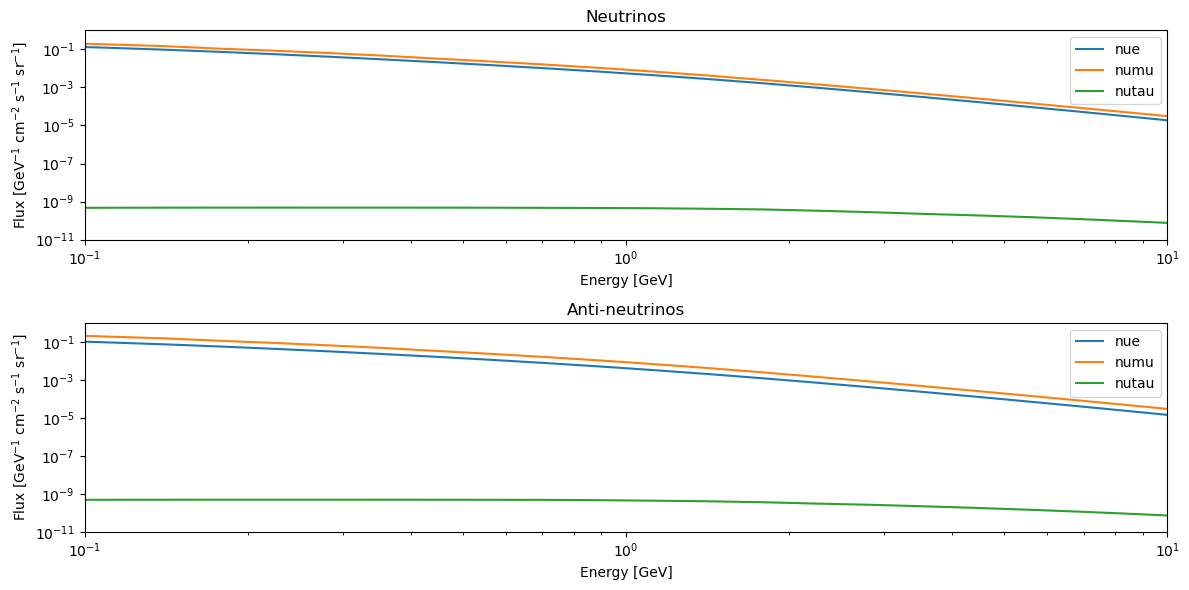

In [9]:
# Calculate the the flux with MCEq and plot it
# This is obsolete for the final analysis, because IceCube used Honda 2015 spl solar min aa
from MCEq.core import MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt

def atmo_nu_flux_mceq(theta_deg=0.0):
    # Initalize MCEq by creating the user interface object MCEqRun
    mceq = MCEqRun(

        # High-energy hadronic interaction model
        interaction_model='SIBYLL23C',

        # cosmic ray flux at the top of the atmosphere
        primary_model = (crf.HillasGaisser2012, 'H3a'),

        # zenith angle
        theta_deg = 0.

    )
    mceq.set_theta_deg(theta_deg)
    mceq.solve()
    #mceq.pman.print_particle_tables(0)
    enubar = mceq.get_solution('antinue')
    enu = mceq.get_solution('nue')
    munubar = mceq.get_solution('antinumu')
    munu = mceq.get_solution('numu')
    taunubar = mceq.get_solution('antinutau')
    taunu = mceq.get_solution('nutau') 

    return mceq, enu, munu, taunu, enubar, munubar, taunubar

mceq, enu, munu, taunu, enubar, munubar, taunubar = atmo_nu_flux_mceq(theta_deg=89.0)

# Plot the flux for each flavor as a function of energy
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax = ax.flatten()
flavors = ['nue', 'numu', 'nutau']

ax[0].loglog(mceq.e_grid, enu, label=flavors[0])
ax[0].loglog(mceq.e_grid, munu, label=flavors[1])
ax[0].loglog(mceq.e_grid, taunu, label=flavors[2])
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_xlim(.1, 10)
ax[0].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax[0].set_ylim(1e-11, 1e0)
ax[0].set_title('Neutrinos')
ax[0].legend()
# Anti-neutrinos
ax[1].loglog(mceq.e_grid, enubar, label=flavors[0])
ax[1].loglog(mceq.e_grid, munubar, label=flavors[1])
ax[1].loglog(mceq.e_grid, taunubar, label=flavors[2])
ax[1].set_xlabel('Energy [GeV]')
ax[1].set_xlim(.1, 10)
ax[1].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax[1].set_ylim(1e-11, 1e0)
ax[1].set_title('Anti-neutrinos')
ax[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# Calculate the flux for different zenith angles
zenith_angles = np.arccos(np.linspace(0, 1, 15, endpoint=True)[::-1])*180/np.pi

mceq_dict = {}
for theta in zenith_angles:
    mceq, enu, munu, taunu, enubar, munubar, taunubar = atmo_nu_flux_mceq(theta)
    mceq_dict[theta] = mceq

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Se

In [11]:
# Sanity checks of MCEq flux
print("Minimum and maximum values interpolator energy: ", min(mceq_dict[zenith_angles[0]].e_grid), max(mceq_dict[zenith_angles[0]].e_grid))
print("Minimum and maximum values interpolator zenith angles: ", min(zenith_angles), max(zenith_angles))
print("Minimum and maximum values interpolator coszen: ", min(np.cos(zenith_angles*np.pi/180+np.pi/2)), max(np.cos(zenith_angles*np.pi/180)))
print(" Minimum and maximum values neutrinos energy: ", min(neutrinos['true_energy']), max(neutrinos['true_energy']))
print(" Minimum and maximum values neutrinos coszen: ", min(neutrinos['true_coszen']), max(neutrinos['true_coszen']))


Minimum and maximum values interpolator energy:  0.08912509381337455 89125093813.37459
Minimum and maximum values interpolator zenith angles:  0.0 90.0
Minimum and maximum values interpolator coszen:  -1.0 1.0
 Minimum and maximum values neutrinos energy:  1.001518 494983.426841
 Minimum and maximum values neutrinos coszen:  -1.0 0.999997


### Functions for normalization and oscillation probabilities

In [12]:
def oscillation_probabilities(neutrinos=neutrinos, 
                       delta_m32: float = 2.53e-3, # eV^2
                       theta_23: float = 49.8, # Degrees
                       **kwargs):
    """
    Calculate neutrino oscillation probabilities.
    For electrons, we set the weights to 1.
    For muons, the return value is P(nu_mu -> nu_mu) = 1 - P(nu_mu -> nu_tau)
    For taus, the return value is P(nu_mu -> nu_tau)
    """
    probabilities = np.ones(neutrinos.shape[0])
    
    is_nu_mu = np.abs(neutrinos['pdg']) == 14
    is_nu_tau = np.abs(neutrinos['pdg']) == 16

    r = 1.3e4/2 # Earth radius [km]
    a = 20 # distance from atmosphere to IceCube [km]
    # Calculate distance traveled by the neutrinos as a function of their true cosZ.
    # This equation can be derived using simple geometry and the law of cosines
    distance = -neutrinos["true_coszen"] * (r-a) + np.sqrt(neutrinos["true_coszen"]**2 * (r-a)**2 - (a**2 - 2*a*r))
    assert np.all(distance >= 20), "Distance is negative!"
    probabilities[is_nu_mu] = 1 - np.sin(2*np.deg2rad(theta_23))**2 * np.sin(1.27 * delta_m32 * distance[is_nu_mu] / neutrinos[is_nu_mu]['true_energy'])**2
    probabilities[is_nu_tau] = np.sin(2*np.deg2rad(theta_23))**2 * np.sin(1.27 * delta_m32 * distance[is_nu_tau] / neutrinos[is_nu_tau]['true_energy'])**2

    assert np.all(probabilities >= 0), "Probabilities are negative!"
    assert np.all(probabilities <= 1), "Probabilities are greater than 1!"
    
    return probabilities


def muon_norm(muon_weights, n_muons):
    """Calculate the normalization constant for muons"""
    mc_count = np.sum(muon_weights)
    return n_muons / mc_count


def neutrino_norm(neutrinos=neutrinos, nu_tau_norm=1., NC_norm=1., **kwargs):
    """
    Apply the normalization factors to the neutrino weights.
    """
    weights = np.ones(neutrinos['weight'].shape)
    # Tau neutrino normalization (table II)
    weights[np.abs(neutrinos['pdg']) == 16] *= nu_tau_norm
    # NC normalization (table II)
    weights[neutrinos['type'] == 0] *= NC_norm
    return weights

def neutrino_total_norm(neutrino_weights, n_neutrinos):
    """Normalize the total neutrino count to be the same as in table I"""
    return n_neutrinos / neutrino_weights.sum()


### Functions for applying Honda fluxes

In [36]:
# TODO: Check which Honda flux table this is. Functions for flux normalization etc.
def get_honda_fluxes(filename: str = "nu_flux_honda_table_2015_spl_solmin.txt"):
    # Create a dict with the pdg as key and an array as value.
    # The arrays are of shape (n, 3) with the energy, cosZ angle, and flux
    fluxes = {-14: [], -12: [], 12: [], 14: []}

    with open(filename) as f:
        for line in f:
            # If the line starts without a space, it contains the cosZ value range (which we take the average over)
            if line[0] != " ":
                cos1, cos2 = float(line[23:27]), float(line[32:36])
                # To make the interpolation work for all values of cosZ, place the outermost points at the edges, i.e., 1 and -1
                if cos1 == 1. or cos2 == 1.:
                    cosZ = 1.
                elif cos1 == -1. or cos2 == -1.:
                    cosZ = -1
                # For other values of cosZ, take the average of the upper and lower bounds
                else:
                    cosZ = (cos1 + cos2)/2
                continue
            
            # If the line starts with a space but the second , it contains numbers
            elif not line[1].isnumeric():
                continue
            
            # Otherwise, it contains the energy and fluxes
            energy, numu_flux, numubar_flux, nue_flux, nuebar_flux = [float(value) for value in line.split()]
            # Maybe the Honda model uses the opposite convention for cosZ?LinearNdIterpoltor is not subscriptable
            # cosZ = -cosZ
            fluxes[12].append([energy, cosZ, nue_flux])
            fluxes[14].append([energy, cosZ, numu_flux])
            fluxes[-12].append([energy, cosZ, nuebar_flux])
            fluxes[-14].append([energy, cosZ, numubar_flux])
    # TODO check that the angle is read correctly.
    fluxes = {key: np.array(value) for key, value in fluxes.items()}
    flux_interpolators = {pdg: scipy.interpolate.LinearNDInterpolator(value[:, :2], value[:, 2]) for pdg, value in fluxes.items()}
    return flux_interpolators

# Assuming nu_mu and nu_tau fluxes are the same and normalizing observed nu_tau later
def apply_flux_honda(neutrinos=neutrinos,
               delta_m32: float = 2.53e-3, # eV^2
               theta_23: float = 49.8, # Degrees
               **kwargs):
    """
    Calculate the flux for the neutrinos based on their true energy and cosZ.
    The Honda flux tables are used.

    Also apply neutrino oscillation probabilities to the weights.
    The weight of a certain (cosZtrue, Etrue) nu_mu is multiplied by P(nu_mu -> nu_mu)
    The weight of a certain (cosZtrue, Etrue) nu_tau is multiplied by P(nu_mu -> nu_tau)
    """
    flux_interpolators = get_honda_fluxes()
    # Apply oscillation probabilities
    oscillation_weights = oscillation_probabilities(neutrinos=neutrinos,
                                delta_m32=delta_m32,
                                theta_23=theta_23)
    # Multiply oscillation weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 16:
            interpolator = flux_interpolators[14]
        elif pdg == -16:
            interpolator = flux_interpolators[-14]
        else:
            interpolator = flux_interpolators[pdg]

        interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen']) # TBD: Check if sign is correct
        #print("\ninterpolated_flux old: \n", interpolated_flux)
        # If the energy of the neutrino is outside the energy range given by the Honda flux table, there are 3 options:
        # - use the flux of the maximum energy allowed by the Honda table, which is 10_000.
        # - drop the events entirely
        # - TODO Use the approximation of E^(-3.7) from the last two points in the Honda table for that zenith angle and extrapolate.
        if (nan_loc := np.isnan(interpolated_flux)).any():
            interpolated_flux[nan_loc] = 0 #interpolator(1e4, neutrinos[mask][nan_loc]["true_coszen"])
        
        oscillation_weights[mask] *= interpolated_flux

    # convert from flux in #particles / (m^2 sec sr GeV) to #particles / sec
    # The cross section of DeepCore depends on the zenith angle
    # but I assume it to be the same for all angles for now.
    # In that case, the cross section does not really matter, since we normalize the events to the number of neutrinos.
    # It is approximately 300 m x 300 m x 300 m, based on Fig. 1 in the paper.
    # NOTE: I cannot multiply by the energy, as that results in a massive discrepancy. 
    # I guess the weights already take it into account, or there is something with integration that makes it unnecessary.
    # oscillation_weights *= 300**2 * neutrinos["true_energy"]
    
    return oscillation_weights

def apply_flux_honda_unosc(neutrinos=neutrinos):
    # To be removed
    '''
    Return the weights without oscillation probabilities
    This doesn't work because of the normalization etc. later on
    '''
    flux_interpolators = get_honda_fluxes()
    weights = np.ones(neutrinos.shape[0])

    # Multiply weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 16:
            interpolator = flux_interpolators[14]
        elif pdg == -16:
            interpolator = flux_interpolators[-14]
        else:
            interpolator = flux_interpolators[pdg]

        interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen'])
        
        # Set energies outside hoda flux table range to 0 
        if (nan_loc := np.isnan(interpolated_flux)).any():
            interpolated_flux[nan_loc] = 0

        weights[mask] *= interpolated_flux

    return weights

### Functions for applying MCEq fluxes

In [14]:
# Functions for applying MCEq flux
def get_MCEq_flux_interpolator(flavor, mceq_dict=mceq_dict):
    """
    Create an interpolator for the MCEq fluxes.
    """
    from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
    import numpy as np

    x = [e for _ in range(2*len(zenith_angles)) for e in mceq_dict[zenith_angles[0]].e_grid]
    y = [np.cos(angle*np.pi/180+sign) for sign in [0, np.pi/2] for angle in zenith_angles for _ in range(len(mceq_dict[zenith_angles[0]].e_grid))] 
    # sign loop is to make the interpolation work for all values of cosZ, since the MCEq fluxes are only calculated for cosZ > 0
    #print("y: ", y)
    z = np.zeros((2*len(zenith_angles), len(mceq_dict[zenith_angles[0]].e_grid)))
    for k in [0, len(zenith_angles)]:
        for i,key in enumerate(mceq_dict.keys()):
            for j in range(len(mceq_dict[key].e_grid)):
                z[i+k][j] = mceq_dict[key].get_solution(flavor)[j]*(1e4) # MCeq flux in #particles / (cm^2 sec sr GeV) to #particles / (m² sec GeV)
    z = z.reshape(-1,1)


    interpolator = NearestNDInterpolator(list(zip(x, y)), z) # NearestNDInterpolator worked where LinearNDInterpolator didn't
    return interpolator


def apply_flux_mceq(neutrinos=neutrinos,
               delta_m32: float = 2.53e-3, # eV^2
               theta_23: float = 49.8, # Degrees
               **kwargs):
    """
    Calculate the flux for the neutrinos based on their true energy and cosZ.
    The MCEq flux is used.

    Also apply neutrino oscillation probabilities to the weights.
    The weight of a certain (cosZtrue, Etrue) nu_mu is multiplied by P(nu_mu -> nu_mu)
    The weight of a certain (cosZtrue, Etrue) nu_tau is multiplied by P(nu_mu -> nu_tau)
    """

    flavors = ['nue', 'numu', 'nutau', 'antinue', 'antinumu', 'antinutau']
    # Apply oscillation probabilities
    oscillation_weights = oscillation_probabilities(neutrinos=neutrinos,
                                delta_m32=delta_m32,
                                theta_23=theta_23)
    
    # Multiply oscillation weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 12:
            interpolator = get_MCEq_flux_interpolator(flavor='nue')
        elif pdg == -12:
            interpolator = get_MCEq_flux_interpolator(flavor='antinue')
        elif pdg == 14:
            interpolator = get_MCEq_flux_interpolator(flavor='numu')
        elif pdg == -14:
            interpolator = get_MCEq_flux_interpolator(flavor='antinumu')
        elif pdg == 16:
            interpolator = get_MCEq_flux_interpolator(flavor='nutau')
        elif pdg == -16:
            interpolator = get_MCEq_flux_interpolator(flavor='antinutau')
        #print("true coszen: ", neutrinos[mask]['true_coszen'])
        interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen']).flatten() # correct order
        #print("\ninterpolated_flux new: \n", interpolated_flux)
        # If the energy of the neutrino is outside the energy, cosZ range MCEq flux is set to nan
        oscillation_weights[mask] *= interpolated_flux # convert from #particles / (cm^2 sec sr GeV) to #particles / (m² sec GeV)

    # convert from flux in #particles / (m^2 sec sr GeV) to #particles / sec
    # The cross section of DeepCore depends on the zenith angle
    # but I assume it to be the same for all angles for now.
    # In that case, the cross section does not really matter, since we normalize the events to the number of neutrinos.
    # It is approximately 300 m x 300 m x 300 m, based on Fig. 1 in the paper.
    # NOTE: I cannot multiply by the energy, as that results in a massive discrepancy. 
    # I guess the weights already take it into account, or there is something with integration that makes it unnecessary.
    # oscillation_weights *= 300**2 * neutrinos["true_energy"]
    
    return oscillation_weights

## Honda vs MCEq
Compare Honda flux to MCEq flux

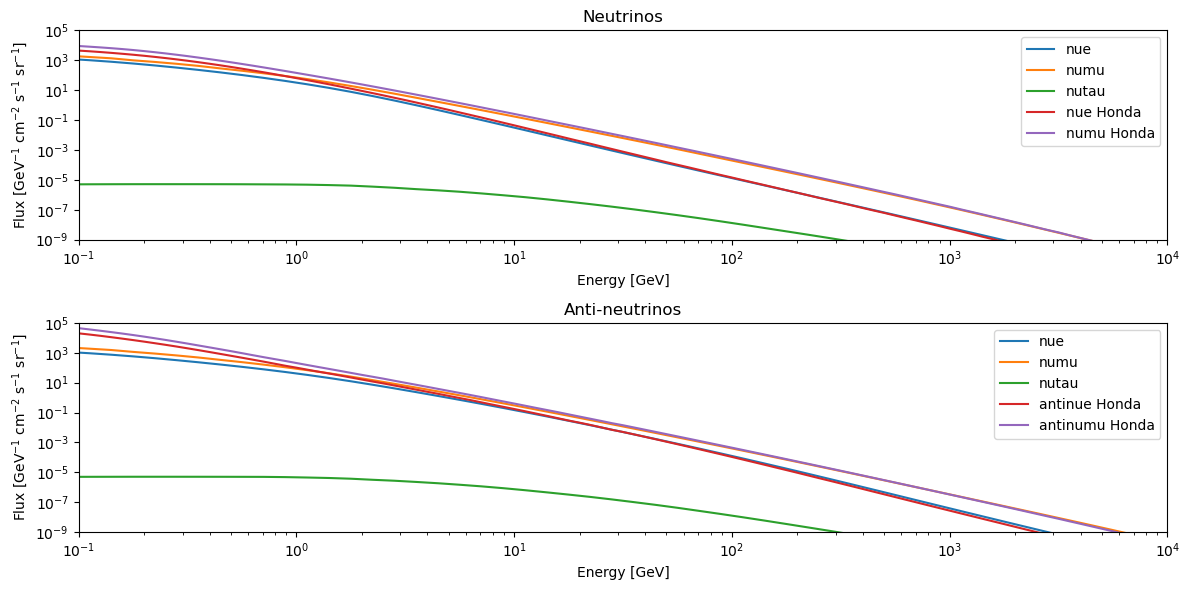

In [15]:
# Plot comparioson of MCEq and Honda fluxes
# Read in the Honda flux
fluxes = {-14: [], -12: [], 12: [], 14: []}

with open("nu_flux_honda_table.txt") as f:
    for line in f:
        # If the line starts without a space, it contains the cosZ value range (which we take the average over)
        if line[0] != " ":
            cos1, cos2 = float(line[23:27]), float(line[32:36])
            # To make the interpolation work for all values of cosZ, place the outermost points at the edges, i.e., 1 and -1
            if cos1 == 1. or cos2 == 1.:
                cosZ = 1.
            elif cos1 == -1. or cos2 == -1.:
                cosZ = -1
            # For other values of cosZ, take the average of the upper and lower bounds
            else:
                cosZ = (cos1 + cos2)/2
            continue
        
        # If the line starts with a space but the second , it contains numbers
        elif not line[1].isnumeric():
            continue
        
        # Otherwise, it contains the energy and fluxes
        energy, numu_flux, numubar_flux, nue_flux, nuebar_flux = [float(value) for value in line.split()]
        # Maybe the Honda model uses the opposite convention for cosZ?LinearNdIterpoltor is not subscriptable
        # cosZ = -cosZ
        fluxes[12].append([energy, cosZ, nue_flux])
        fluxes[14].append([energy, cosZ, numu_flux])
        fluxes[-12].append([energy, cosZ, nuebar_flux])
        fluxes[-14].append([energy, cosZ, numubar_flux])
#
# Get Honda flux at the horizon
#
horizon_flux = {-14: [], -12: [], 12: [], 14: []}
# print all values of fluxes[12] for cosZ = 0.0
for j in range(len(fluxes[12])):
        if fluxes[12][j][1] <= 0.05 and fluxes[12][j][1] > -0.05:
            horizon_flux[12].append(fluxes[12][j])
        if fluxes[14][j][1] <= 0.05 and fluxes[14][j][1] > -0.05:
            horizon_flux[14].append(fluxes[14][j])
        if fluxes[-12][j][1] <= 0.05 and fluxes[-12][j][1] > -0.05:
            horizon_flux[-12].append(fluxes[-12][j])
        if fluxes[-14][j][1] <= 0.05 and fluxes[-14][j][1] > -0.05:
            horizon_flux[-14].append(fluxes[-14][j])
# numpify the horizon_flux
for key, value in horizon_flux.items():
    horizon_flux[key] = np.array(value)

#
# Get Honda flux at a specific cosZ
#     
coszenup = -0.9
coszenlow = -1
other_flux = {-14: [], -12: [], 12: [], 14: []}
for j in range(len(fluxes[12])):
    if fluxes[12][j][1] <= coszenup and fluxes[12][j][1] >= coszenlow:
        other_flux[12].append(fluxes[12][j])
    if fluxes[14][j][1] <= coszenup and fluxes[14][j][1] >= coszenlow:
        other_flux[14].append(fluxes[14][j])
    if fluxes[-12][j][1] <= coszenup and fluxes[-12][j][1] >= coszenlow:
        other_flux[-12].append(fluxes[-12][j])
    if fluxes[-14][j][1] <= coszenup and fluxes[-14][j][1] >= coszenlow:
        other_flux[-14].append(fluxes[-14][j]) 
# numpify the other_flux
for key, value in other_flux.items():
    other_flux[key] = np.array(value)


# Convert the values in fluxes to numpy arrays
fluxes = {key: np.array(value) for key, value in fluxes.items()}

#
# Plot the flux for each flavor as a function of energy
#
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax = ax.flatten()
flavors = ['nue', 'numu', 'nutau']
num =0
# Neutrinos
for i, (flux, label) in enumerate(zip(["nue", "numu", "nutau"], flavors)):
    ax[0].loglog(mceq_dict[zenith_angles[num]].e_grid, mceq_dict[zenith_angles[num]].get_solution(flux)*(1e4), label=label)
# Horizon flux
#ax[0].loglog(horizon_flux[12][:,0], horizon_flux[12][:,2], label="nue Honda")
#ax[0].loglog(horizon_flux[14][:,0], horizon_flux[14][:,2], label="numu Honda")    
# Flux at specific cosZ
ax[0].loglog(other_flux[12][:,0], other_flux[12][:,2], label="nue Honda")
ax[0].loglog(other_flux[14][:,0], other_flux[14][:,2], label="numu Honda")
for j, (pdg, flux) in enumerate(zip([12, 14, 16], [fluxes[12], fluxes[14], fluxes[14]])): # assume tau flux is the same as muon flux
    ax[0].set_xlabel('Energy [GeV]')
    ax[0].set_xlim(.1, 1e4)
    ax[0].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]') # Honda flux (m^2 sec sr GeV)^-1
    ax[0].set_ylim(1e-9, 1e5)
    ax[0].set_title('Neutrinos')
    ax[0].legend()

# Anti-neutrinos
for i, (flux, label) in enumerate(zip(["antinue", "antinumu", "antinutau"], flavors)):
    ax[1].loglog(mceq_dict[90.0].e_grid, mceq_dict[90.0].get_solution(flux)*(1e4), label=label)

ax[1].loglog(horizon_flux[-12][:,0], horizon_flux[-12][:,2], label="antinue Honda")
ax[1].loglog(horizon_flux[-14][:,0], horizon_flux[-14][:,2], label="antinumu Honda")
for j, (pdg, flux) in enumerate(zip([-12, -14, -16], [fluxes[-12], fluxes[-14], fluxes[-14]])): # assume tau flux is the same as muon flux
    ax[1].set_xlabel('Energy [GeV]')
    ax[1].set_xlim(.1, 1e4)
    ax[1].set_ylabel('Flux [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
    ax[1].set_ylim(1e-9, 1e5)
    ax[1].set_title('Anti-neutrinos')
    ax[1].legend()

plt.tight_layout()



Honda flux and MCEq flux agree for (anti)nue and (anti)numu

## Plot MC

### MCEq

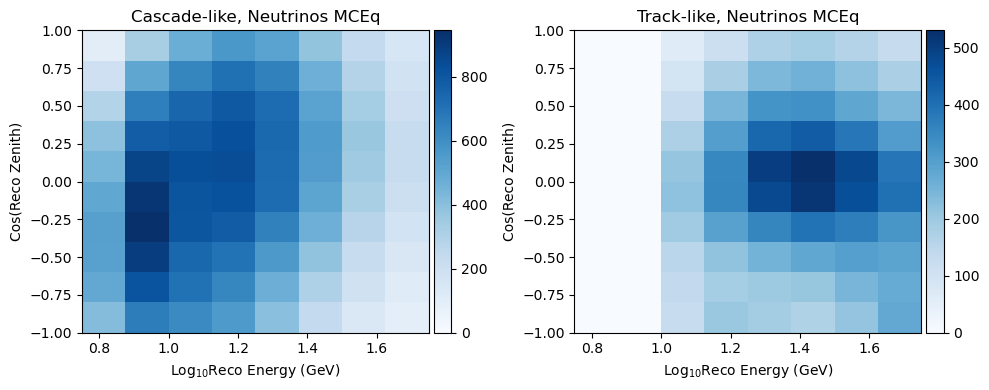

In [16]:
# Make a plot of the neutrinos just to verify the shape is correct (MCEq)
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# I also apply neutrino oscillation probabilities
neutrino_weights *= apply_flux_mceq(**best_fit)
# Scale to the livetime of the data
neutrino_weights *= 1006*24*3600. 
# Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
neutrino_weights *= neutrino_norm(**best_fit)
# Scale the neutrino weights based on the total number of neutrinos according to table I
neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93) # 93 noise triggers, 5022 atmospheric muons

# save neutrino weights to txt file
np.savetxt("neutrino_weights_mceq.txt", neutrino_weights)

# Make the histogram, binning in energy, zenith, and pid
nu_hist, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights)
nu_hist = np.swapaxes(nu_hist, 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights**2)[0]
)
# Swap axis 0 and 1 to match the data formagridflat and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist.max())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,1],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist[:,:,1].max())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos MCEq')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos MCEq')

fig.tight_layout()

### Honda

##### with normalization

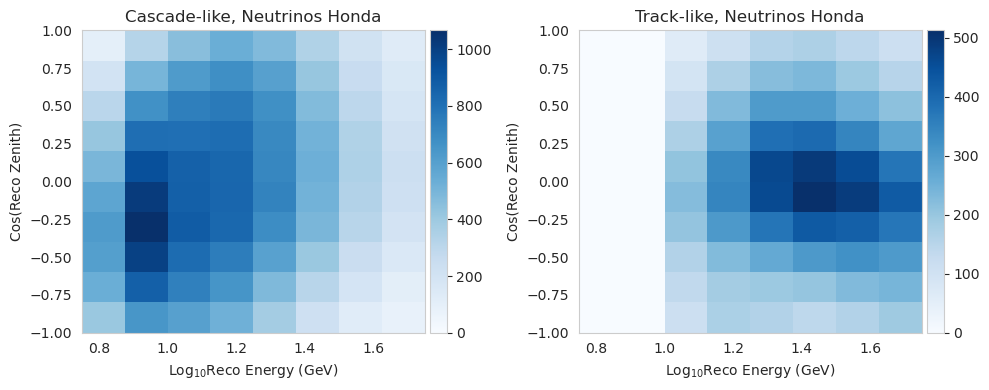

In [37]:
# Make a plot of the neutrinos just to verify the shape is correct (Honda)
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])

bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# I also apply neutrino oscillation probabilities
neutrino_weights *= apply_flux_honda(**best_fit)

# Scale to the livetime of the data
neutrino_weights *= 1006*24*3600. 
# Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
neutrino_weights *= neutrino_norm(**best_fit)
# Scale the neutrino weights based on the total number of neutrinos according to table I
neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93)

# Make the histogram, binning in energy, zenith, and pid
nu_hist_honda, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights)
nu_hist_honda = np.swapaxes(nu_hist_honda, 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights**2)[0]
)
# Swap axis 0 and 1 to match the data formagridflat and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda[:,:,0],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda.max())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda[:,:,1],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda[:,:,1].max())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos Honda')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos Honda')

fig.tight_layout()

#### MC Honda without normalization

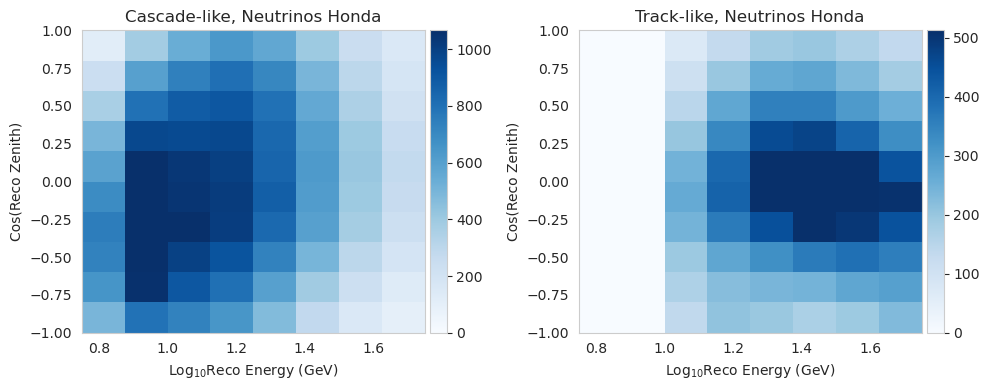

In [38]:
# Make a plot of the neutrinos just to verify the shape is correct (Honda)
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])

bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights_no_normalization = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# I also apply neutrino oscillation probabilities
neutrino_weights_no_normalization *= apply_flux_honda(**best_fit)

# Scale to the livetime of the data
neutrino_weights_no_normalization *= 1006*24*3600. 
# Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
#neutrino_weights *= neutrino_norm(**best_fit)
# Scale the neutrino weights based on the total number of neutrinos according to table I
#neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93)

# Make the histogram, binning in energy, zenith, and pid
nu_hist_honda_no_normalization, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights_no_normalization)
nu_hist_honda_no_normalization  = np.swapaxes(nu_hist_honda_no_normalization , 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights_no_normalization**2)[0]
)
# Swap axis 0 and 1 to match the data formagridflat and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda_no_normalization[:,:,0],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda.max())
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda_no_normalization[:,:,1],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda[:,:,1].max())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos Honda')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos Honda')

fig.tight_layout()

#### Plot oscillated vs unoscillated MC Honda

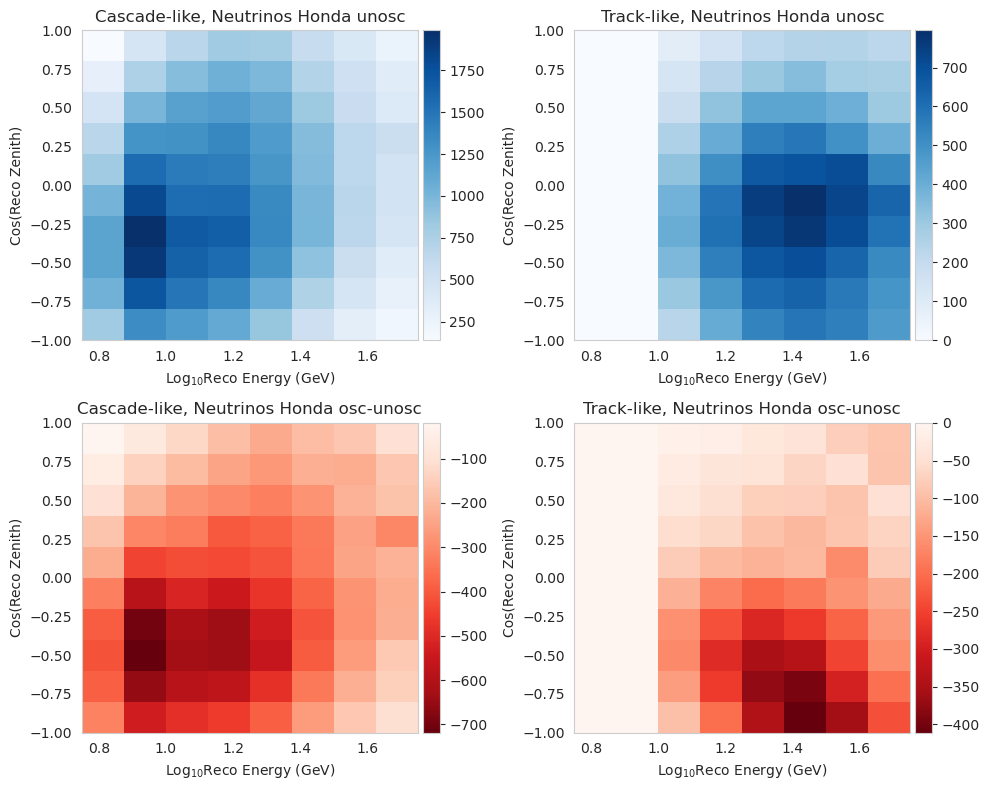

In [39]:
# Calculate unoscillated neutrino weights
unosc_neutrino_weights = neutrino_weights_no_normalization / oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)

unosc_honda_hist, _ = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights)

unosc_honda_hist = np.swapaxes(unosc_honda_hist, 0, 1)

# Make a figure
fig, ((ax1, ax2), (ax3, ax4) )= plt.subplots(2,2, figsize=(10, 8))
cmesh = ax1.pcolormesh(bins_en,
                       bins_cz,
                       unosc_honda_hist[:,:,0],
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                          bins_cz,
                          unosc_honda_hist[:,:,1],
                          cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax3.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda_no_normalization[:,:,0]-unosc_honda_hist[:,:,0],
                       cmap='Reds_r')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax4.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist_honda_no_normalization[:,:,1]-unosc_honda_hist[:,:,1],
                       cmap='Reds_r')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos Honda unosc')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos Honda unosc')
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax3.set_title('Cascade-like, Neutrinos Honda osc-unosc')
ax3.set_ylabel("Cos(Reco Zenith)")
ax3.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax4.set_ylabel("Cos(Reco Zenith)")
ax4.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax4.set_title('Track-like, Neutrinos Honda osc-unosc')

fig.tight_layout()

Maybe I should inlcude the full oscillation probabilities

## Plot comparison of MC with MCEq and MC with Honda flux

In the end, we want to use the Honda flux, because it is the one that was used by the IceCube collaboraiton

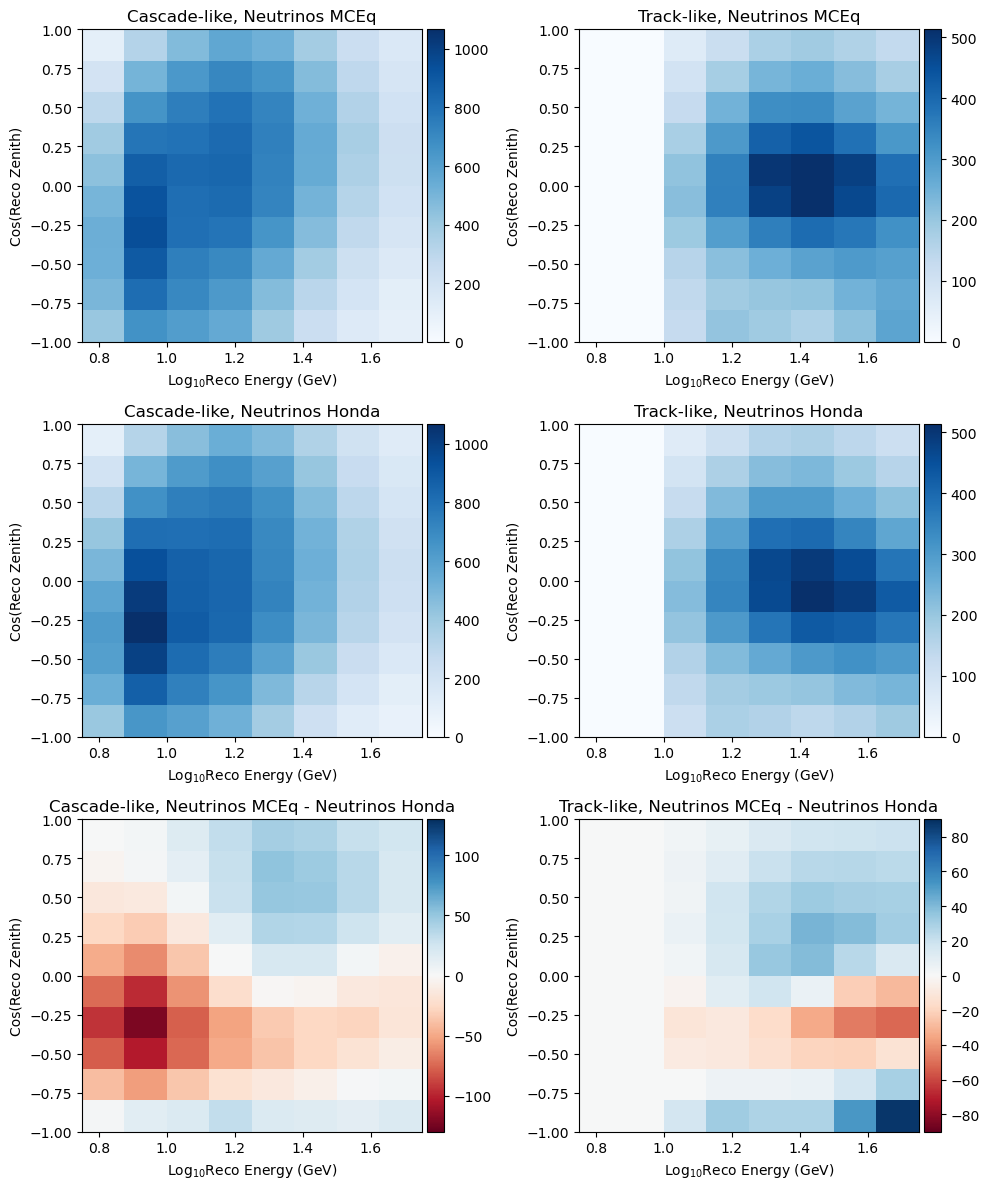

In [20]:
# Plot Honda and MCEq MC next to each other and their difference

# Make a figure
fig, axs = plt.subplots(3,2, figsize=(10, 12))
cmesh = axs[0,0].pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda.max())
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = axs[0,1].pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,1],
                       cmap='Blues',
                       vmin=0, vmax=nu_hist_honda[:,:,1].max())
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = axs[1,0].pcolormesh(bins_en,
                        bins_cz,
                        nu_hist_honda[:,:,0],
                        cmap='Blues',
                       vmin=0, vmax=nu_hist_honda.max())
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = axs[1,1].pcolormesh(bins_en,
                        bins_cz,
                        nu_hist_honda[:,:,1],
                        cmap='Blues',
                       vmin=0, vmax=nu_hist_honda[:,:,1].max())
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = axs[2,0].pcolormesh(bins_en,
                        bins_cz,
                        nu_hist[:,:,0] - nu_hist_honda[:,:,0],
                        cmap='RdBu',
                        vmin=-130, vmax=130)
divider = make_axes_locatable(axs[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = axs[2,1].pcolormesh(bins_en,
                        bins_cz,
                        nu_hist[:,:,1] - nu_hist_honda[:,:,1],
                        cmap='RdBu',
                        vmin=-90, vmax=90)
divider = make_axes_locatable(axs[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

axs[0,0].set_title('Cascade-like, Neutrinos MCEq')
axs[0,0].set_ylabel("Cos(Reco Zenith)")
axs[0,0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[0,1].set_ylabel("Cos(Reco Zenith)")
axs[0,1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[0,1].set_title('Track-like, Neutrinos MCEq')
axs[1,0].set_title('Cascade-like, Neutrinos Honda')
axs[1,0].set_ylabel("Cos(Reco Zenith)")
axs[1,0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[1,1].set_title('Track-like, Neutrinos Honda')
axs[1,1].set_ylabel("Cos(Reco Zenith)")
axs[1,1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[2,0].set_title('Cascade-like, Neutrinos MCEq - Neutrinos Honda')
axs[2,0].set_ylabel("Cos(Reco Zenith)")
axs[2,0].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
axs[2,1].set_title('Track-like, Neutrinos MCEq - Neutrinos Honda')
axs[2,1].set_ylabel("Cos(Reco Zenith)")
axs[2,1].set_xlabel(r"Log$_{10}$Reco Energy (GeV)")

fig.tight_layout()

10% difference is significant... 
TODO: Find out why this happens even though fluxes (on log scale) appear similar

## Plot muon MC

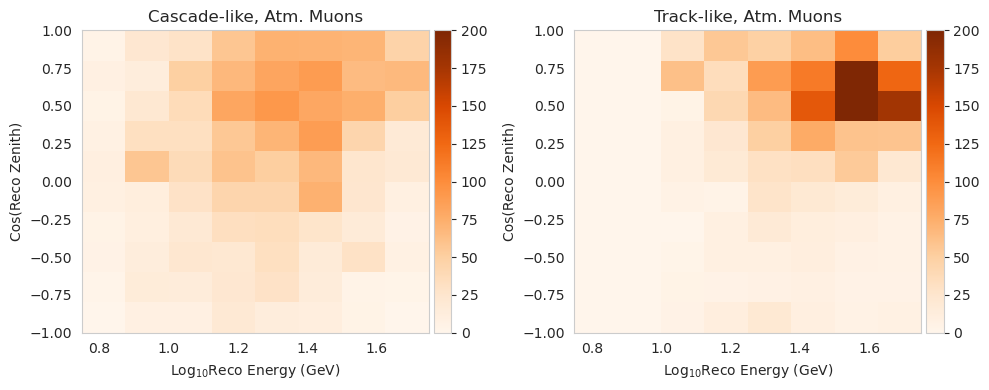

In [42]:
# Make a plot of the muons just to verify the shape is correct (Muons)
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#muon_weights = np.copy(muons['weight'])
#muon_weights = apply_muons()
muon_weights = apply_muons(**best_fit)

# Weights are in Hz. Convert to about the 
# livetime given in Section IV
# Corresponding to the number of seconds that the experiment was live. 
# Roughly 3 years.
muon_weights *= 1006*24*3600. 

# Scale the number of events so that they match the numbers in table I
muon_weights *= muon_norm(muon_weights, 5022)

# Make the histogram, binning in energy, zenith, and pid
muon_hist, edges = np.histogramdd([np.log10(muons['reco_energy']),
                                   muons['reco_coszen'],
                                   muons['pid']],
                                  bins = [bins_en, bins_cz, bins_pid],
                                  weights = muon_weights)
muon_hist = np.swapaxes(muon_hist, 0, 1)
# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics. See same code above for neutrinos
muon_err = np.sqrt(
    np.histogramdd([np.log10(muons['reco_energy']),
                    muons['reco_coszen'],
                    muons['pid']],
        bins = [bins_en, bins_cz, bins_pid],
        weights = muon_weights**2)[0]
)
muon_err = np.swapaxes(muon_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,0],
                       cmap='Oranges', 
                       vmax=200)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,1],
                       cmap='Oranges',
                       vmax=200)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Atm. Muons')

ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Atm. Muons')

fig.tight_layout()

This plot should look like Figure 12 in the paper, but does not. 
Something with the weights is wrong, or I have misunderstood the output or the plot in the paper.

## Plot detected data

In [22]:
# Read in data and sort it
data = np.genfromtxt("./data.csv", delimiter=',', names=True)

cascades = data[data["pid"] == 0]
tracks = data[data["pid"] == 1]

# Reshape the count column in the cascade array into a 2D array. 
# The rows should correspond to a sorted reco_coszen and the columns should be the sorted reco_energy
cascades_count = cascades["count"].reshape((len(bins_en)-1, len(bins_cz)-1)).T[::-1, ...]
track_count = tracks["count"].reshape((len(bins_en)-1-2, len(bins_cz)-1)).T[::-1, ...]

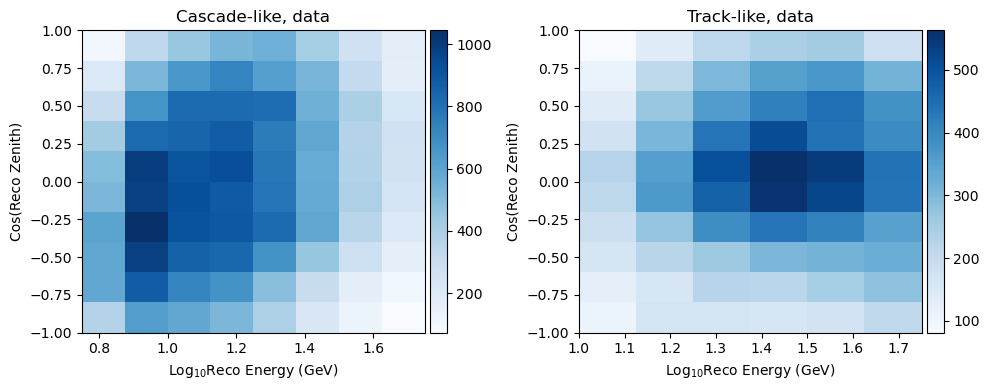

In [23]:
# Make a figure of neutrino data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       cascades_count,
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en[2:], 
                       bins_cz,
                       track_count,
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, data')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, data')

fig.tight_layout()


## Plot comparison of data with MC prediction

/tmp/ipykernel_11769/1967556067.py:55: RuntimeWarning: invalid value encountered in divide
  (nu_hist_honda[:,:,1] + muon_hist[:,:,1]-track_padded)/track_padded,


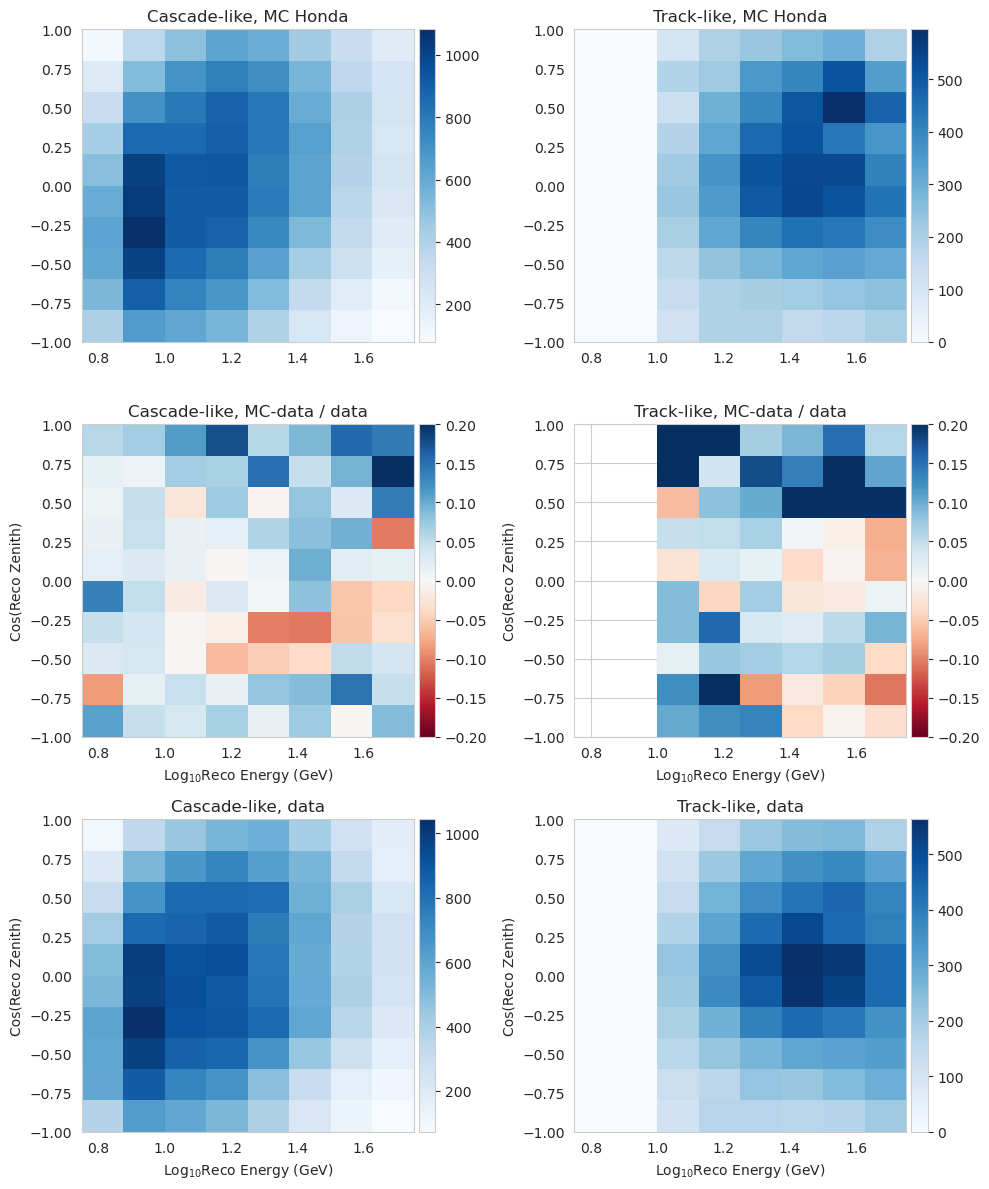

In [40]:
# Data and MC comparison with MCEq and Honda fluxes
# Make a a 3x2 grid of subplots with 2D histograms. 
# The top two rows should be the combined MC data (i.e. neutrinos and muons)
# The bottom row should be the data
fig, ((ax_1,ax0), (ax1, ax2), (ax3, ax4)) = plt.subplots(3,2, figsize=(10, 12))
cmesh = ax_1.pcolormesh(bins_en,
                        bins_cz,
                        nu_hist_honda[:,:,0] + muon_hist[:,:,0],
                        cmap='Blues')
ax_1.set_title('Cascade-like, MC Honda')
divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax0.pcolormesh(bins_en,
                        bins_cz,
                        nu_hist_honda[:,:,1] + muon_hist[:,:,1],
                        cmap='Blues')
ax0.set_title('Track-like, MC Honda')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax3.pcolormesh(bins_en,
                        bins_cz,
                        cascades_count,
                        cmap='Blues')
ax3.set_title('Cascade-like, data')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

track_padded = np.pad(track_count, ((0,0),(2,0)), 'constant', constant_values=0)
cmesh = ax4.pcolormesh(bins_en,
                        bins_cz,
                        track_padded,
                        cmap='Blues')
ax4.set_title('Track-like, data')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       (nu_hist_honda[:,:,0] + muon_hist[:,:,0]-cascades_count)/cascades_count,
                       cmap='RdBu',
                        vmin = -.2, vmax = .2)
ax1.set_title('Cascade-like, MC-data / data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                        bins_cz,
                        (nu_hist_honda[:,:,1] + muon_hist[:,:,1]-track_padded)/track_padded,
                        cmap='RdBu',
                        vmin = -.2, vmax = .2)
ax2.set_title('Track-like, MC-data / data')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylabel("Cos(Reco Zenith)")
    ax.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")


fig.tight_layout()

### Compare data with Honda MC on 1D projections

### Tracks and Cascades stacked

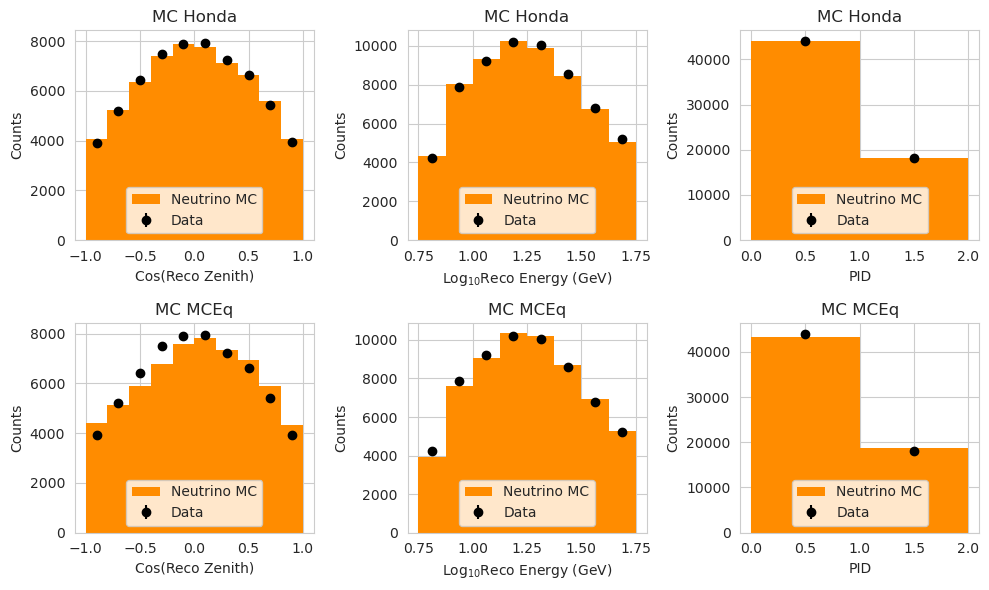

In [43]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count
data_hist = np.stack([cascades_count, track_padded], axis=-1)
# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(2,3, figsize=(10, 6))
for j in range(2):
    axes= axs[j]
    for i, (ax, bins, xlabel) in enumerate(zip(axes, [bins_cz, bins_en, bins_pid], ("Cos(Reco Zenith)", r"Log$_{10}$Reco Energy (GeV)", "PID"))):
        axes_to_sum = tuple(set(range(3)) - set([i]))
        if j == 0:
            nu_mc_proj = nu_hist_honda.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum)
            # set title
            ax.set_title("MC Honda")
        else:
            nu_mc_proj = nu_hist.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum)
            # set title
            ax.set_title("MC MCEq")

        data_proj = data_hist.sum(axis=axes_to_sum)
        ax.stairs(nu_mc_proj, bins, fill=True, alpha=1, label="Neutrino MC", color="darkorange")
        ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=np.sqrt(data_proj), fmt='o', label="Data", c="k")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Counts")
        ax.legend()

fig.tight_layout()

The plots match much better now. This is good! 
However, there is still quite a large discrepancy. 
Maybe this is due to the interpolation being bad, maybe it is because of scaling of all events, maybe a bug in my flux calculation code.
TODO: test all these potential problems.
I do not see any scaling parameter for all events among the nuisance parameters. There is one normalization parameter for the NC events, so I will try to use that. 
I can try to apply a scaling of all events anyway to see if that gives a better result, and read in the paper if there is any mention of it.

# Leggett-Garg inequality

## Functions

In [58]:
import seaborn as sns

def Kn(n,theta):
    '''
    Definition Leggett-Garg parameter 
    '''
    sumCos = 0
    sumAngles = 0
    for m in range(n-1):
        sumCos += np.cos(theta[m])
        sumAngles += theta[m]
    return sumCos - np.cos(sumAngles)
# Defalt values
EARTH_DIAMETER_km = 12742.
EARTH_RADIUS_km = EARTH_DIAMETER_km / 2.
DEFAULT_ATMO_PROD_HEIGHT_km = 22. # Value used in nuSQuIDS
DEFAULT_ATMO_DETECTOR_DEPTH_km = 1. # Value used in nuSQuIDS
km_to_eV = 5.06773093741e9 # [km] -> [1/eV]
GeV_to_eV = 1e9 # [GeV] -> [eV]

def calc_path_length_from_coszen(cz, r=EARTH_RADIUS_km, h=DEFAULT_ATMO_PROD_HEIGHT_km, d=DEFAULT_ATMO_DETECTOR_DEPTH_km) :
    '''
    Get the path length (baseline) for an atmospheric neutrino,
    given some cos(zenith angle).

    cz = cos(zenith) in radians, to be converted to path length in km
    r = Radius of Earth, in km
    h = Production height in atmosphere, in km
    d = Depth of detector (w.r.t. Earth's radius), in km
    '''
    return -r*cz +  np.sqrt( (r*cz)**2 - r**2 + (r+h+d)**2 )

def muon_survival_prob(L_km=None, E_GeV=None, L_km_over_E_GeV=None, best_fit=best_fit):
    '''
    Prediction of muon survival probability
    '''
    if L_km_over_E_GeV is None:
        return 1 - np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km/E_GeV)**2
    else:
        return 1 - np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(1/4*km_to_eV/GeV_to_eV*best_fit["delta_m32"] * L_km_over_E_GeV)**2
    

## Theoretical signal

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_11769/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
/tmp/ipykernel_11769/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
/tmp/ipykernel_11769/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
/tmp/ipykernel_11769/2823286669.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xticklabels(['$\p

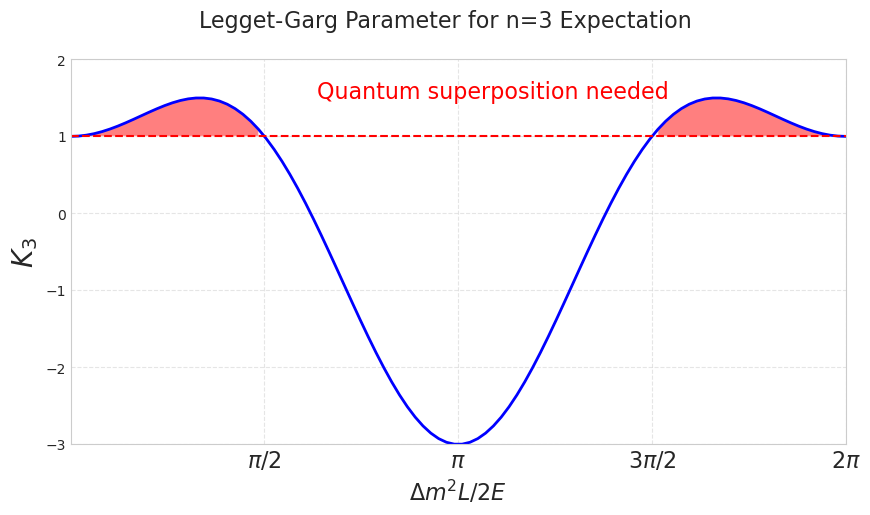

In [28]:
# Plotting for n=3
n=3
theta = np.linspace(0,2*np.pi,100)

K = np.zeros(100)
for i in range(100):
    K[i] = Kn(n,[theta[i],theta[i],theta[i]])

# Set seaborn style
sns.set_style("whitegrid")

# Plot the Legget-Garg parameter
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(theta, K, color='blue', linewidth=2) 
plt.axhline(y=1, color='r', linestyle='--') # Dashed line at y=1
plt.fill_between(theta, K, 1, where=K>1, facecolor='red', alpha=0.5) # Fill the region where K>1
plt.text(2, 1.5, "Quantum superposition needed", fontsize=16, color='red')

# Set xticks
ax.set_xticks([np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-3, 2)

ax.set_xlabel(r"$\Delta m^2L/2E$", fontsize=16)
ax.set_ylabel(r"$K_3$", fontsize=20)
fig.suptitle("Legget-Garg Parameter for n=3 Expectation", fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)
# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# Make ticks face inwards
ax.tick_params(direction='in')


In [29]:
# Extract mu neutrinos
int_type = (np.abs(neutrinos["pdg"]) == 14).astype(int) # non-mu neutrino is 0, mu neutrino NC is 1
int_type[(int_type == 1) & (neutrinos["type"] > 0)] = 2 # mu CC is 2

nonmu = neutrinos[int_type == 0]
mu_nc = neutrinos[int_type == 1]
mu_cc = neutrinos[int_type == 2]

# Make histograms
nonmu_hist, _ = np.histogramdd([np.log10(nonmu['reco_energy']),
                                 nonmu['reco_coszen'],
                                 nonmu['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 0])

nonmu_hist = np.swapaxes(nonmu_hist, 0, 1)

mu_nc_hist, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                 mu_nc['reco_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 1])

mu_nc_hist = np.swapaxes(mu_nc_hist, 0, 1)

mu_cc_hist, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                 mu_cc['reco_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 2])

mu_cc_hist = np.swapaxes(mu_cc_hist, 0, 1)

## Muon Neutrinos with Honda MC

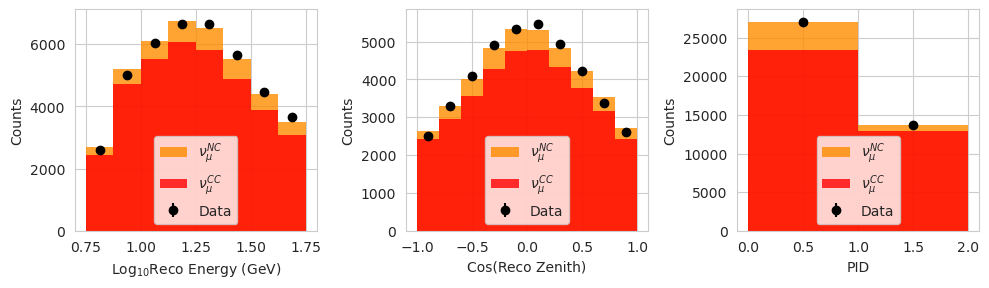

In [44]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count

data_signal_hist = data_hist - muon_hist - nonmu_hist


# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, ax, bins, xlabel in zip((1, 0, 2), axs, [bins_en, bins_cz, bins_pid], (r"Log$_{10}$Reco Energy (GeV)", "Cos(Reco Zenith)", "PID")):
    axes_to_sum = tuple(set(range(3)) - set([i]))
    mu_nc_mc_proj = mu_nc_hist.sum(axis=axes_to_sum)
    mu_cc_mc_proj = mu_cc_hist.sum(axis=axes_to_sum)

    data_proj = data_signal_hist.sum(axis=axes_to_sum)
    # NOTE This is not perfectly accurate, since the MC errors are not a simple Poisson error
    data_proj_err = np.sqrt(
        np.sqrt(data_hist.sum(axis=axes_to_sum))**2 
        + np.sqrt(muon_hist.sum(axis=axes_to_sum))**2 
        + np.sqrt(nonmu_hist.sum(axis=axes_to_sum))**2)

    ax.stairs(mu_nc_mc_proj + mu_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$", color="darkorange")
    ax.stairs(mu_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$", color="red")
    ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=data_proj_err, fmt='o', label="Data", c="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Counts")
    ax.legend()
fig.tight_layout()

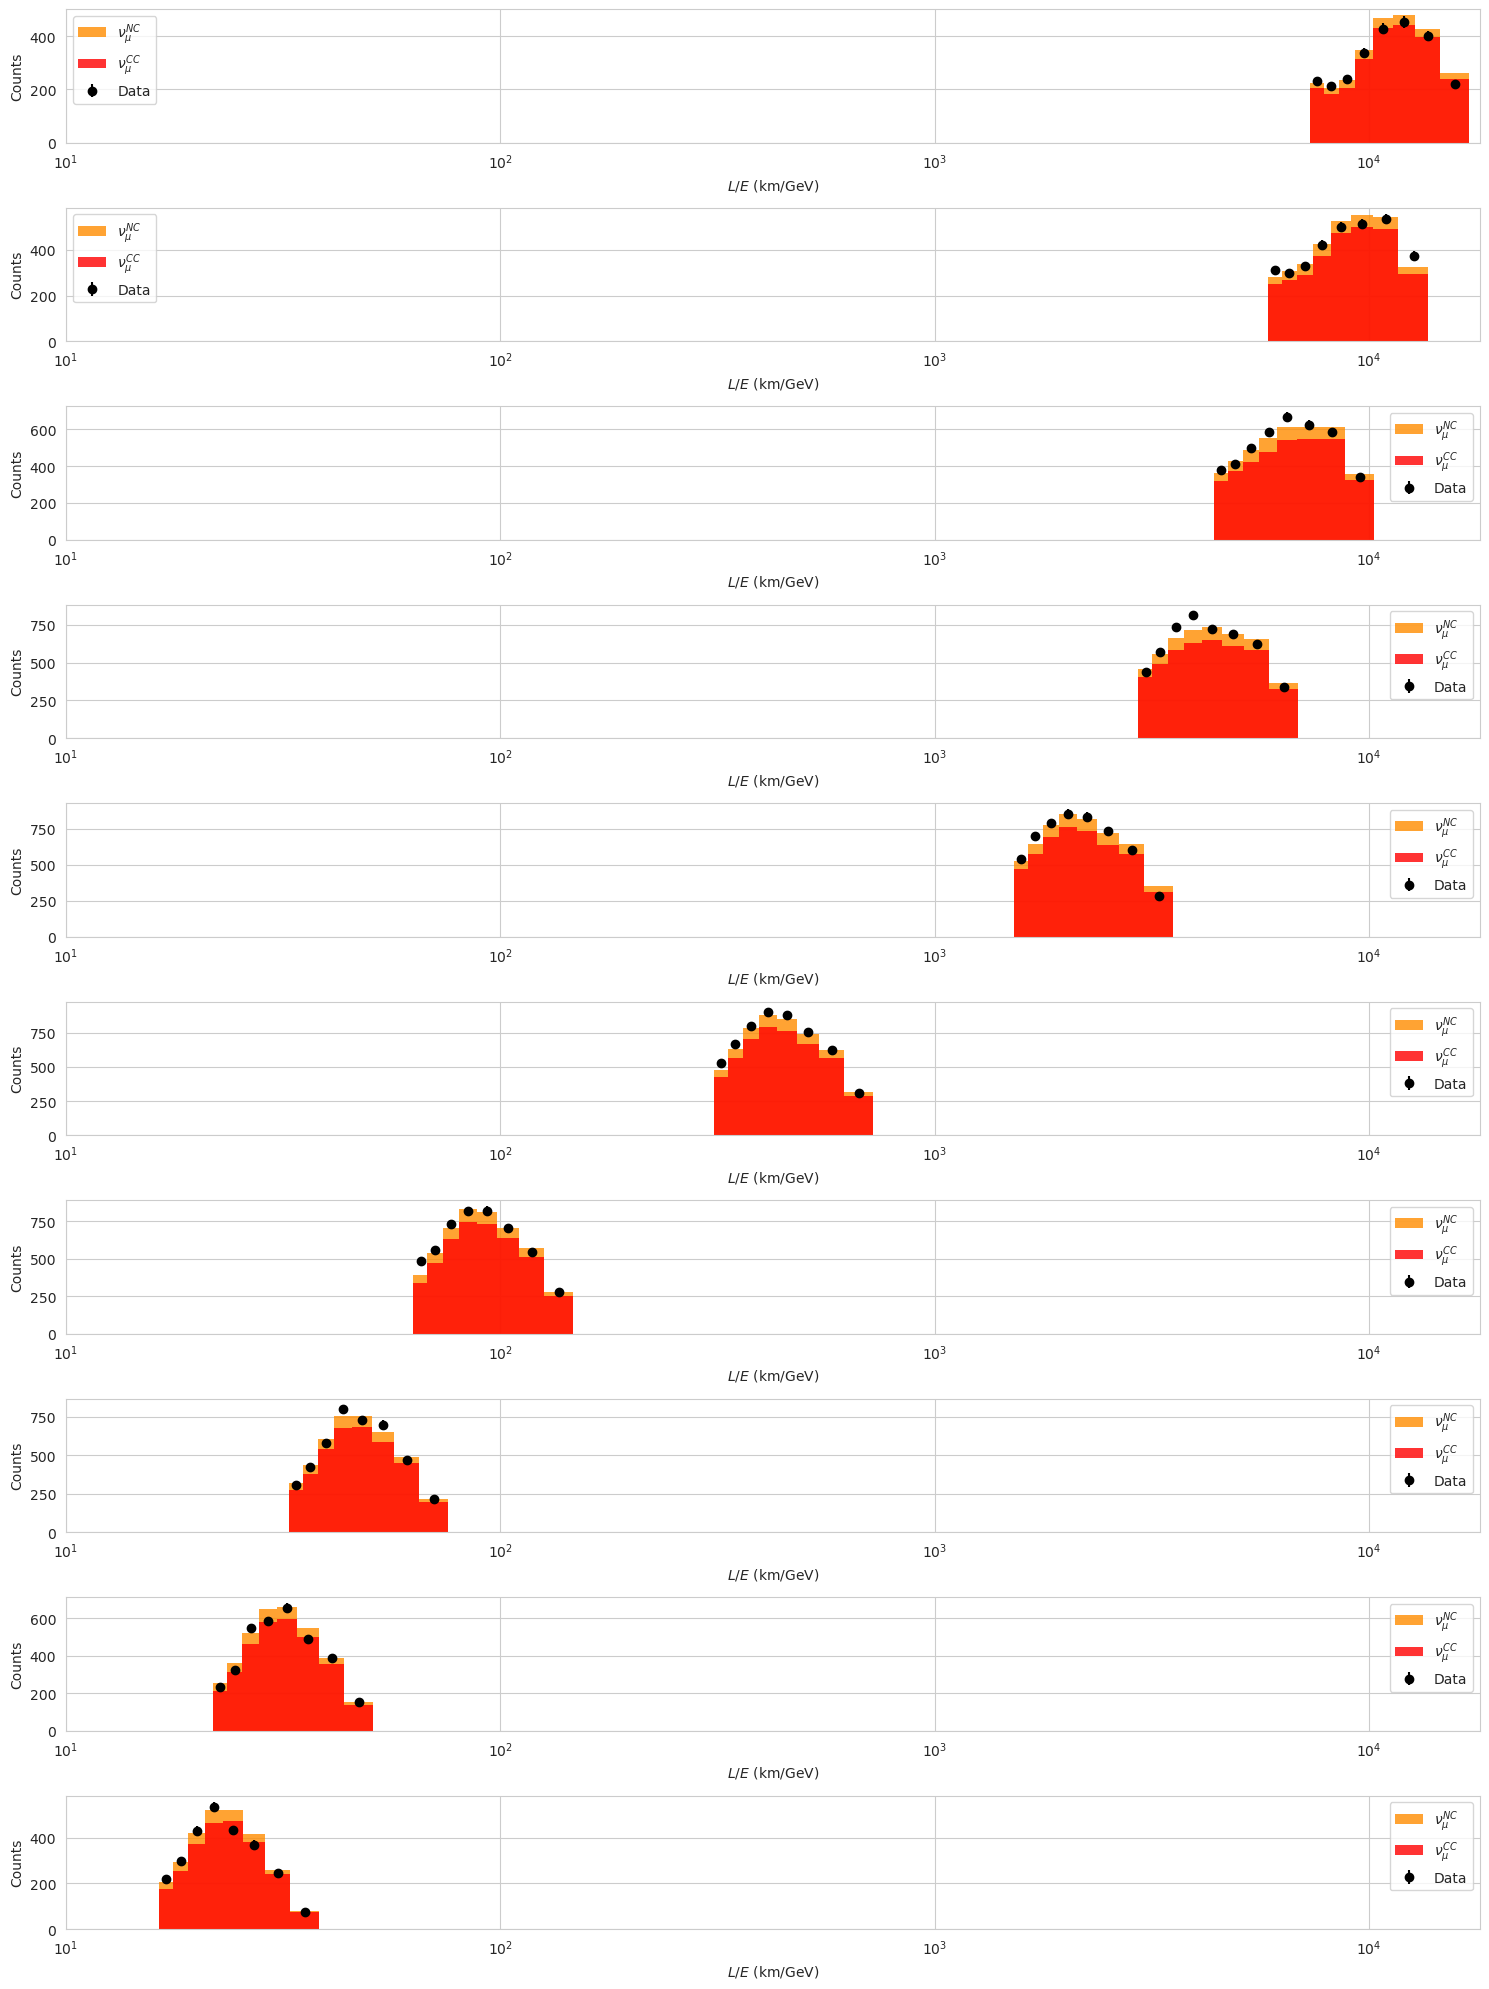

In [45]:
bins_pathlength = calc_path_length_from_coszen(bins_cz)
# combine bins_pathlength and bins_en
L_over_E = bins_pathlength[:, np.newaxis] / bins_en

fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    ax.stairs(mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$", color="darkorange")
    ax.stairs(mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$", color="red")
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i], yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]), fmt='o', label="Data", c="k")
    # plot on a secondary y-axis the muon neutrino survival probability
    #ax2 = ax.twinx()
    #ax2.plot(L_over_E[i], muon_survival_prob(L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(10, 18000)
    ax.set_ylabel("Counts")
    ax.legend()
    # make x axis logarithmic
    ax.set_xscale('log')

fig.tight_layout()

## Plot muon neutrino survival probability

Osc mu neutrino count :
 [349.00411834 644.26894122 715.80969203 818.69419726 853.96720404
 773.53809539 645.58883211 525.14123647]
Unosc mu neutrino count :
 [ 519.48895272  941.76003851 1014.70777074 1120.8198754  1103.35474444
  923.05047784  725.9671356   559.69830715]
Data count :
 [283.25749884 600.90321227 730.93450222 832.8675567  853.58015091
 785.04421919 697.42621917 539.76104852]


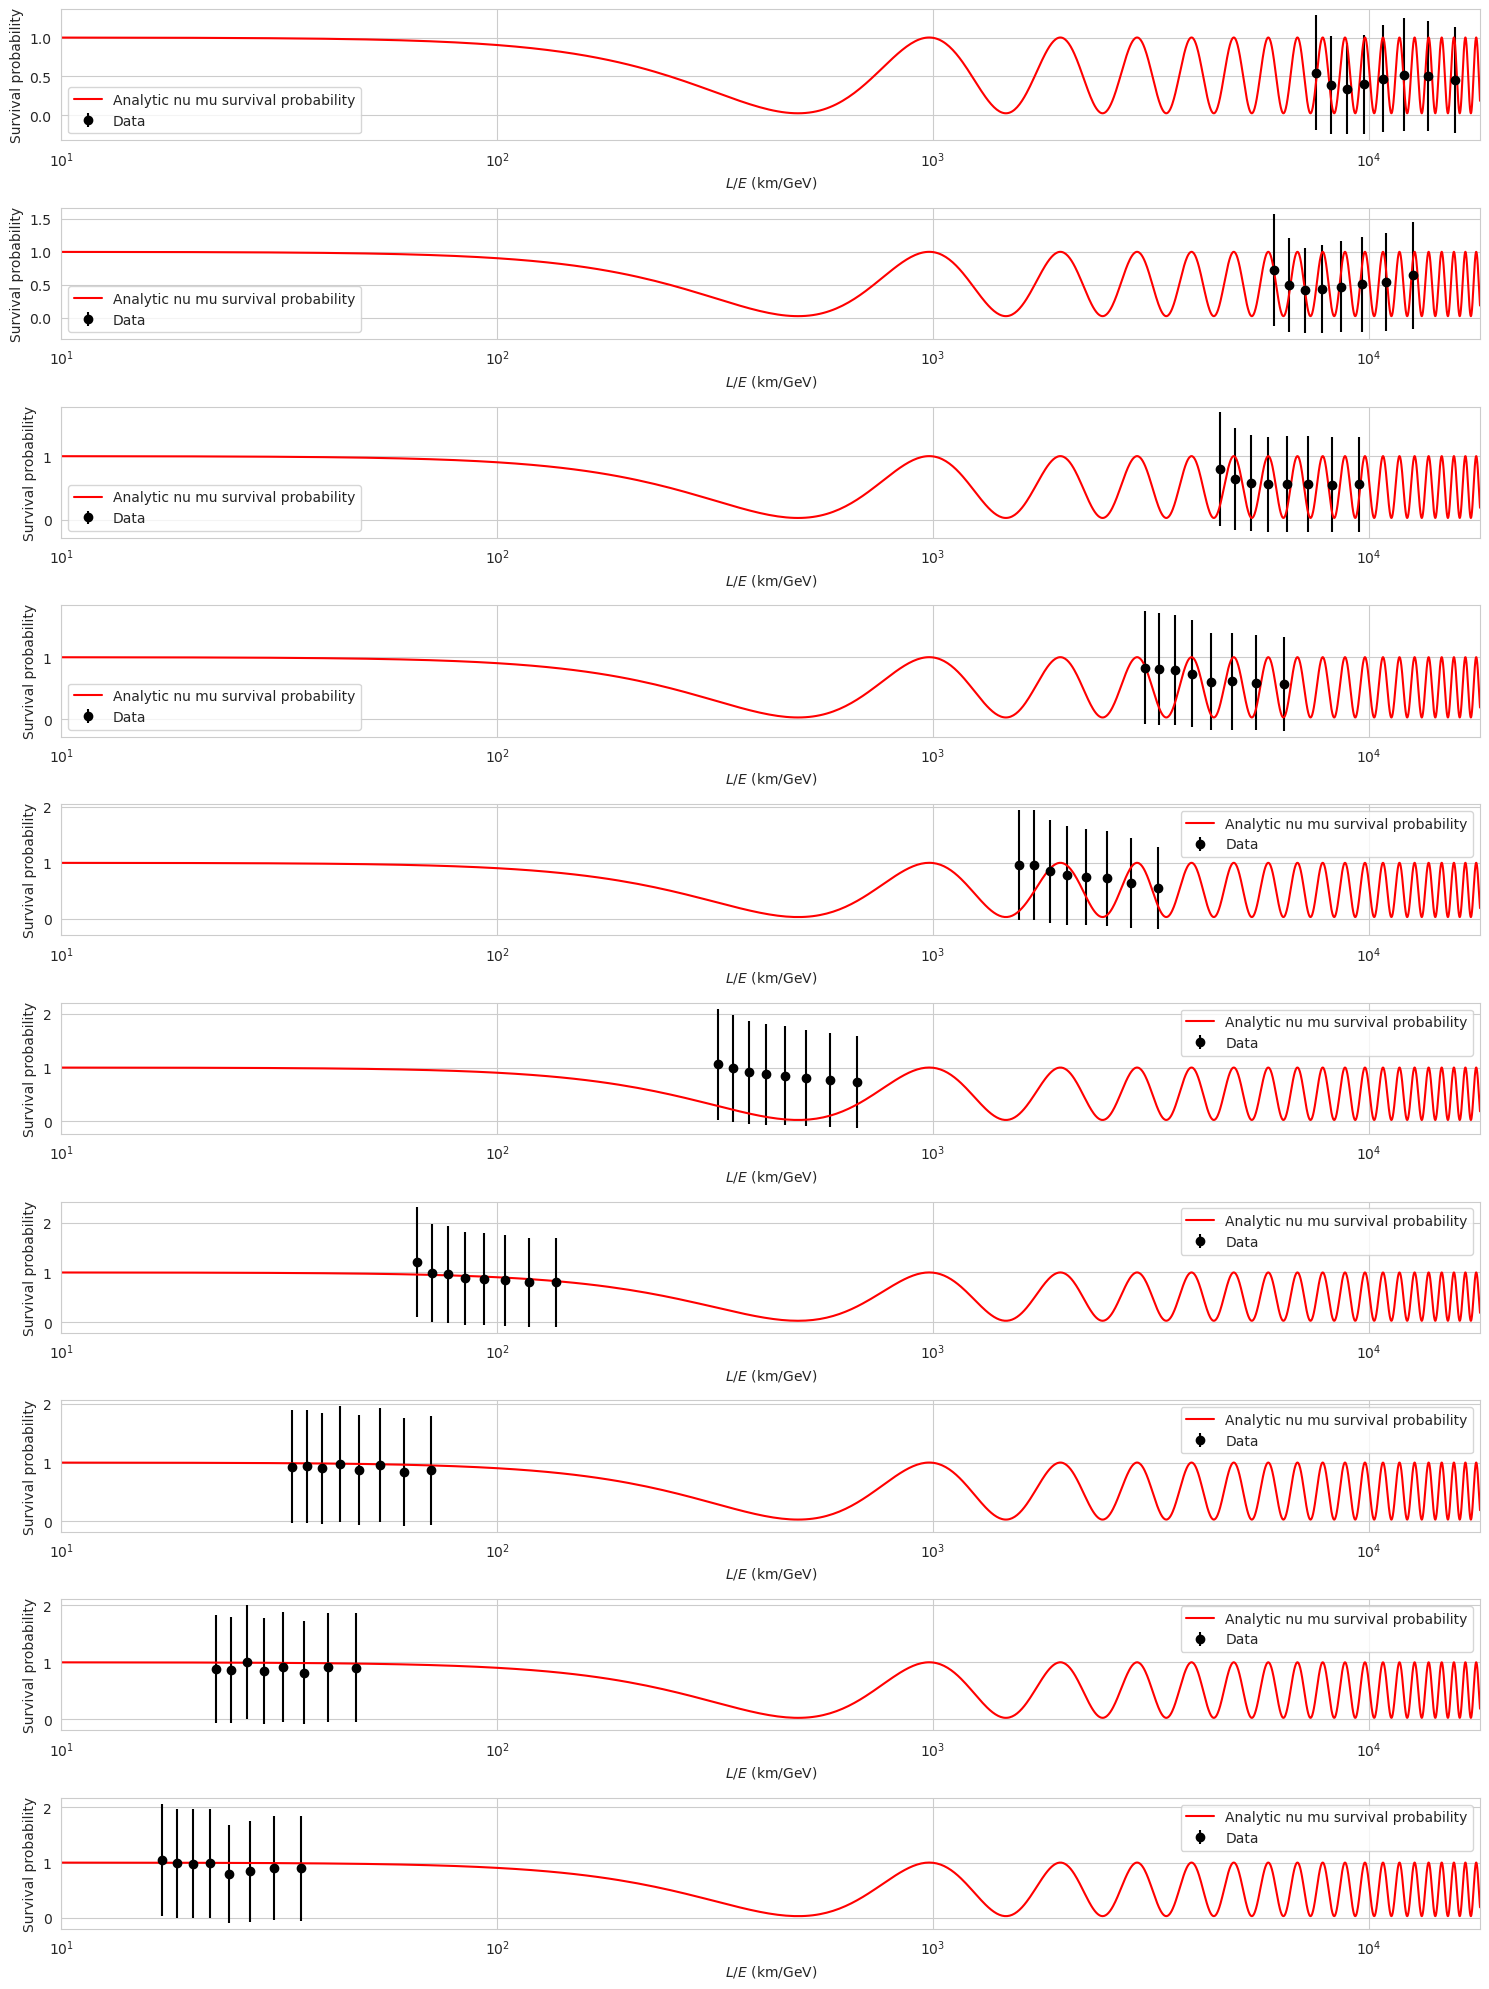

In [59]:
# Calculate unoscillated neutrino weights
unosc_neutrino_weights = neutrino_weights / oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)

unosc_mu_nc_hist, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                 mu_nc['reco_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 1])

unosc_mu_nc_hist = np.swapaxes(unosc_mu_nc_hist, 0, 1)

unosc_mu_cc_hist, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                 mu_cc['reco_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 2])

unosc_mu_cc_hist = np.swapaxes(unosc_mu_cc_hist, 0, 1)

bins_pathlength = calc_path_length_from_coszen(bins_cz)
# combine bins_pathlength and bins_en
L_over_E = bins_pathlength[:, np.newaxis] / bins_en

fig, axs= plt.subplots(10,1, figsize=(15, 20))
for i, ax in zip(range(len(bins_cz)-1), axs):
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i])), fmt='o', label="Data", c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability') # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(10, 18000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    # make x axis logarithmic
    ax.set_xscale('log')
    if i == 4:
        print("Osc mu neutrino count :\n", (mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i]))
        print("Unosc mu neutrino count :\n", (unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]))
        print("Data count :\n", data_signal_hist.sum(axis=2)[i])
        

fig.tight_layout()

#### Second attempt

(1299038,) (1299038,)


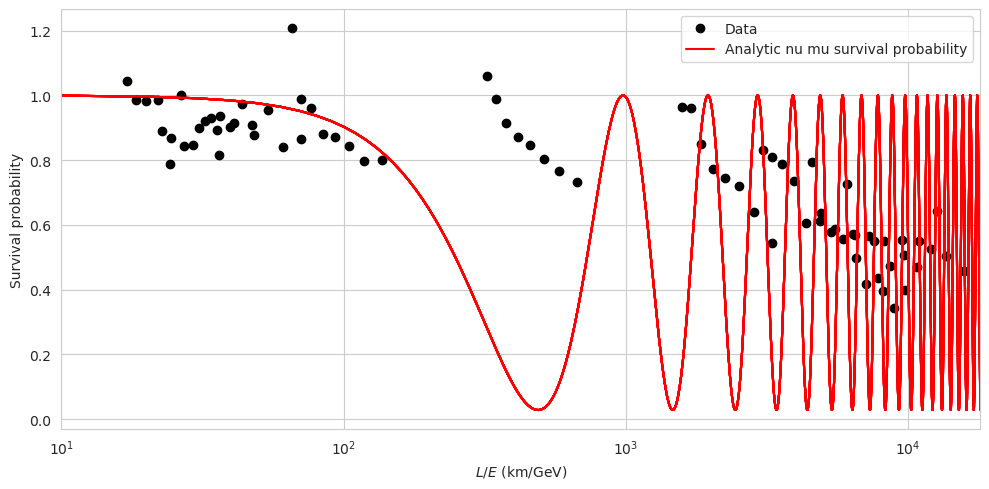

In [48]:
oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)
# Calculate unoscillated neutrino weights
unosc_neutrino_weights = neutrino_weights / oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8)
print(neutrino_weights.shape, oscillation_probabilities(neutrinos=neutrinos, delta_m32=2.53e-3, theta_23=49.8).shape)
unosc_mu_nc_hist, _ = np.histogramdd([np.log10(mu_nc['reco_energy']),
                                 mu_nc['reco_coszen'],
                                 mu_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 1])

unosc_mu_nc_hist = np.swapaxes(unosc_mu_nc_hist, 0, 1)

unosc_mu_cc_hist, _ = np.histogramdd([np.log10(mu_cc['reco_energy']),
                                 mu_cc['reco_coszen'],
                                 mu_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = unosc_neutrino_weights[int_type == 2])

unosc_mu_cc_hist = np.swapaxes(unosc_mu_cc_hist, 0, 1)

bins_pathlength = calc_path_length_from_coszen(bins_cz)
# combine bins_pathlength and bins_en
L_over_E = bins_pathlength[:, np.newaxis] / bins_en

fig, ax= plt.subplots(figsize=(10, 5))
for i in range(len(bins_cz)-1):
    ax.plot((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i]/(unosc_mu_nc_hist.sum(axis=2)[i] + unosc_mu_cc_hist.sum(axis=2)[i]), 'o', label="Data" if i == 0 else None, c="k")
    #ax.plot(L_over_E[i], muon_survival_prob(L_km_over_E_GeV=L_over_E[i]), color='blue', label="Muon neutrino survival probability")
    ax.plot(np.linspace(0, 1e5, 10000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0, 1e5, 10000)), color='red', label='Analytic nu mu survival probability' if i == 0 else None) # sin²(m²L/4E)
    ax.set_xlabel(r"$L/E$ (km/GeV)")
    ax.set_xlim(10, 18000)
    ax.set_ylabel("Survival probability")
    ax.legend()
    ax.set_xscale('log')
        

fig.tight_layout()

(11, 9)


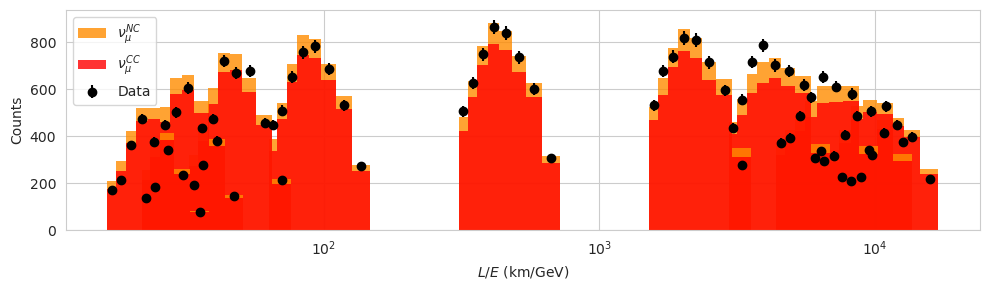

In [34]:
bins_pathlength = calc_path_length_from_coszen(bins_cz)
# combine bins_pathlength and bins_en
L_over_E = bins_pathlength[:, np.newaxis] / bins_en
print(L_over_E.shape)

fig, ax = plt.subplots(figsize=(10, 3))
for i in range(len(bins_cz)-1):
    ax.stairs(mu_nc_hist.sum(axis=2)[i] + mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{NC}$" if i == 0 else None, color="darkorange")
    ax.stairs(mu_cc_hist.sum(axis=2)[i], L_over_E[i], fill=True, alpha=0.8, label=r"$\nu_\mu^{CC}$" if i == 0 else None, color="red")
    ax.errorbar((L_over_E[i][1:] + L_over_E[i][:-1])/2, data_signal_hist.sum(axis=2)[i], yerr=np.sqrt(data_signal_hist.sum(axis=2)[i]), fmt='o', label="Data" if i == 0 else None, c="k")
#ax.errorbar((L_over_E.flatten()[1:] + L_over_E.flatten()[:-1])/2, data_signal_hist.sum(axis=2).flatten(), yerr=data_proj_err.flatten(), fmt='o', label="Data", c="k")
ax.set_xlabel(r"$L/E$ (km/GeV)")
ax.set_ylabel("Counts")
ax.legend()
ax.set_xscale('log')
fig.tight_layout()

In [64]:
L_over_E.shape

(11, 9)

### Scatter plot of all the possible combinations of L/E


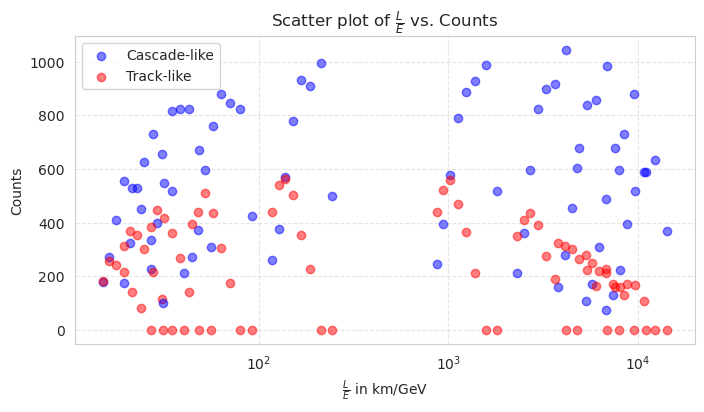

In [102]:
# calculate centers of bins
bins_cz_centers = (bins_cz[1:] + bins_cz[:-1]) / 2
bins_en_centers = (bins_en[1:] + bins_en[:-1]) / 2
bins_pathlength_centers = calc_path_length_from_coszen(bins_cz_centers)

# Scatter plot of all L/E values
fig, ax = plt.subplots(figsize=(8, 4))
for i, L in enumerate(bins_pathlength_centers):
    for j, E in enumerate(bins_en_centers):
        ax.scatter(L/E, data_hist[i,j,0], color='blue', alpha=0.5, label='Cascade-like' if i==0 and j==0 else None)
        ax.scatter(L/E, data_hist[i,j,1], color='red', alpha=0.5, label='Track-like' if i==0 and j==0 else None)
        
#ax.plot(np.linspace(0, 1e5, 1000), 1e3* (1 - np.sin(2*np.deg2rad(best_fit["theta_23"]))**2 * np.sin(best_fit["delta_m32"] * np.linspace(0, 1e5, 1000)/4)**2), color='grey', label='Survival prob') # sin²(m²L/4E)
ax.set_xlabel(r"$\frac{L}{E}$ in km/GeV")
ax.set_ylabel("Counts")
ax.set_title("Scatter plot of $\\frac{L}{E}$ vs. Counts")
ax.set_xscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


In [81]:
data_hist[:, :, 0].shape


(10, 8)

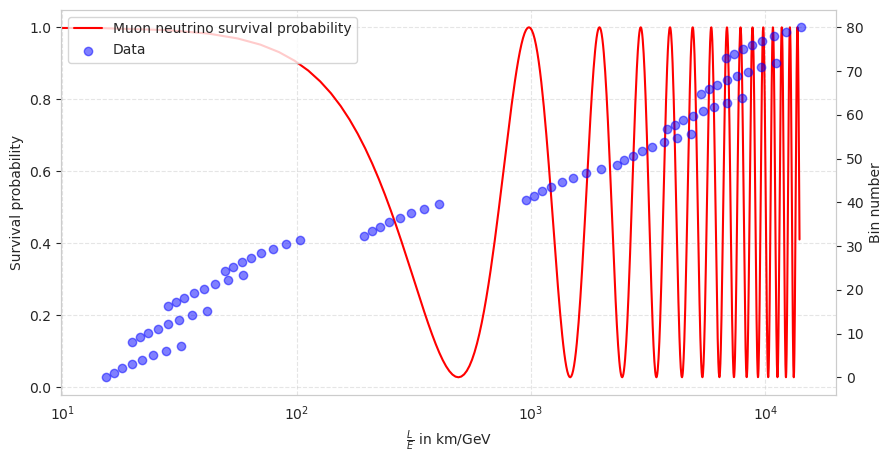

In [138]:
L_over_E_bin_centers = (L_over_E[:, 1:] + L_over_E[:, :-1]) / 2
L_bin_centers_over_E_bin_centers = (L_over_E_bin_centers[1:, :] + L_over_E_bin_centers[:-1, :])/2
# plot bin centers in growing order
fig, ax = plt.subplots(figsize=(10, 5))
# plot on a second y axis oscillation probability
ax2 = ax.twinx()
ax.plot(np.linspace(0,14000,1000), muon_survival_prob(L_km_over_E_GeV=np.linspace(0,14000,1000)), color='red', label="Muon neutrino survival probability")
ax2.scatter(L_bin_centers_over_E_bin_centers.flatten()[::-1], np.linspace(0,80,80), color='blue', alpha=0.5, label='Data')

ax.set_xlabel(r"$\frac{L}{E}$ in km/GeV")
ax2.set_ylabel("Bin number")
ax.set_ylabel("Survival probability")#
ax.set_xscale('log')
# Combine the legends of ax and ax2
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")
ax.grid(True, linestyle='--', alpha=0.5)
ax2.grid(False)
plt.show()



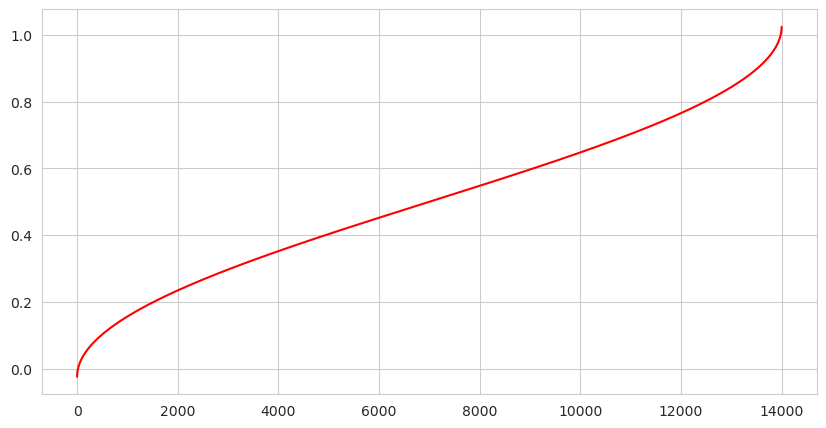

In [137]:
# plot arcsin
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(0,14000,10000), ((np.arcsin(2*np.linspace(0,14000,10000)/14000-1)+1.5)/3), color='red', label="arcsin")


In [68]:
# Calculate all possible combinations of L_over_E that form a tripple such that L_over_E[i] + L_over_E[j] = L_over_E[k] within the bins
L_over_E = bins_pathlength[:, np.newaxis] / bins_en
L_over_E_combinations = np.array([L_over_E[i] + L_over_E[j] for i in range(len(bins_cz)-1) for j in range(len(bins_cz)-1)])
bins_pathlength = calc_path_length_from_coszen(bins_cz)
np.log(bins_en)
# Space between bins in log space
np.diff(np.log(bins_en))






array([0.1541507 , 0.1335314 , 0.11778306, 0.10536051, 0.09531016,
       0.08701137, 0.08004271, 0.07410796])

## Calculate $\chi^2$ value
The data above is the sum of all backgrounds (muon background, non-neutrino backgrounds, and tau neutrino interactions). This should then be compared to the sum of all simulated backgrounds and signal to calculate how well the two distributions match. This is done using a $\chi^2$ test. The $\chi^2$ value is defined as:
$$
\chi^2 = \sum_{i\in \{bins\}} \frac{(N_i^{exp} - N_i^{obs})^2}{N_i^{exp} + (\sigma_i^{exp})^2} + \sum_{j\in\{syst\}} \frac{(s_j - \hat s_j)^2}{\sigma_{s_j}^2}
$$

- $N_i^{exp}$: expected number of events in bin $i$
- $N_i^{obs}$: observed number of events in bin $i$
- $\sigma_i^{exp}$: statistical uncertainty in bin $i$ due to the finite statistics of MC simulations. <!-- Maybe this can be calculated using the weighted errors of the MC events stored in the csv files? TODO ask Chad and Jason -->
- $s_j$: central value of nuisance parameter $j$
- $\hat s_j$: maximum likelihood estimate of nuisance parameter $j$
- $\sigma_{s_j}$: uncertainty in nuisance parameter $j$, from the Gaussian standard deviation of the nuisance parameter

The nuisance parameters, their standard deviations, and their best fit values can be found in table II of the paper.

The final $\chi^2$ value that was achieved for the best fit of all nuisance parameters was 127.6, so we expect to get a similar value.

Later, we want to change the value of the tau normalization to check what $\chi^2$ values we get in those situations.

In [ ]:
# Calculate systematic uncertainties
nuisance_parameters = pd.DataFrame({
    "nue_numu_ratio": [1.0, 0.05, 1.03, 1.03],
    "nue_up_hor_flux_ratio": [0.0, 1., -0.42, -0.33],
    "spectral_index": [0., 0.1, 0.03, 0.03],
    "effective_livetime": [np.nan, np.nan, 2.21, 2.24],
    "M_A_quasielastic": [0.99, (0.248+0.149)/2, 1.05, 1.05], # Upper and lower bounds
    "M_A_resonance": [1.12, 0.22, 1., 0.99],
    "NC_norm": [1., 0.2, 1.05, 1.06],
    "theta_13": [8.5, 0.21, np.nan, np.nan],
    "theta_23": [np.nan, np.nan, 49.8, 50.2],
    "delta_m2_32": [np.nan, np.nan, 2.53, 2.56],
    "opt_eff_all": [100, 10, 98.4, 98.4],
    "opt_eff_lat": [0, 1, 0.49, 0.48],
    "opt_eff_headon": [np.nan, np.nan, -0.63, -0.64],
    "bulk_ice_scattering": [100, 10, 103, 102.8],
    "bulk_ice_absorption": [100, 10, 101.5, 101.7],
    "atm_mu_frac": [np.nan, np.nan, 8.1, 8.0],
    "mu_spectral_index": [0., 1., 0.15, 0.15],
    "coin_nu_mu_frac": [0., 0.1, 0.01, 0.01],   # TODO only +, not +-. Maybe the standard deviation is a fraction of 0.1?
    "nu_tau_norm": [np.nan, np.nan, 0.73, 0.57]
}, index=["prior", "prior_error", "best_fit_cc_nc", "best_fit_cc"]).T
nuisance_parameters

,prior,prior_error,best_fit_cc_nc,best_fit_cc
nue_numu_ratio,1.00,0.0500,1.03,1.03
nue_up_hor_flux_ratio,0.00,1.0000,-0.42,-0.33
spectral_index,0.00,0.1000,0.03,0.03
effective_livetime,NaN,NaN,2.21,2.24
M_A_quasielastic,0.99,0.1985,1.05,1.05
M_A_resonance,1.12,0.2200,1.00,0.99
NC_norm,1.00,0.2000,1.05,1.06
theta_13,8.50,0.2100,NaN,NaN
theta_23,NaN,NaN,49.80,50.20
delta_m2_32,NaN,NaN,2.53,2.56


In [ ]:
systematics = nuisance_parameters.dropna(axis=0)
sys_chi2 = np.sum((systematics["prior"] - systematics["best_fit_cc_nc"])**2 / systematics["prior_error"]**2)
sys_chi2

1.4884860019687816

In [ ]:
# MC total expected event counts
mc_hist = nu_hist + muon_hist
# Error on the number of events due to the limited MC statistics. 
# TODO can we add these errors like this? I think so but worth double-checking
mc_err = np.sqrt(nu_err**2 + muon_err**2)

In [ ]:
def chi2(mc_hist, cascades_count, track_count, mc_err, sys_chi2):
    mc_cascades = mc_hist[:,:,0]
    mc_tracks = mc_hist[:,2:,1]
    mc_cascade_err = mc_err[:,:,0]
    mc_track_err = mc_err[:,2:,1]

    chi2 = (
        np.sum((mc_cascades - cascades_count)**2 / (mc_cascades + mc_cascade_err**2))
        + np.sum((mc_tracks - track_count)**2 / (mc_tracks + mc_track_err**2))
        + sys_chi2
    )
    return chi2

chi2(mc_hist, cascades_count, track_count, mc_err, sys_chi2)

155.9183978162569